# Contents
1. [Assumptions](#assumptions)
2. [Naive Attempt (comparison with other users)](#naive1)
3. [Naive Attempt (comparison with himself)](#naive2)

# 1. Some assumptions <a name="assumptions"></a>

- one participant has always the similar health status in the same exercise repetitions in one day, but because in this research the health status need to be quantized, health status from the same participant but during different exercise, even during differrent should be considered as also different. Then one can measure and compare health status in different exercise and repetitions
- one participant has the similar health status in different exercises in one day, but these measured values from these similar health status belong to different distribution under changing health status. 
- the performance of one participant in the same day is stable, this restriction used to evaluate a standardization method

# 2. Naive attempt 1, standardize all exercises' score using the same exercise number <a name="naive1"></a>

### 2.1 assumptions 
in this part a z-score method is used to standardize all score of different participant in the same exercise. Assume that health status of one in each repetition are different. therefore each repetition is regarded as an individual experiment. Only the same participant in different repititions in the same exercise should be seem as different participant with similar health status. This Assumption causes variance of the distribution on all 

just normalize each exercise respectively 

In [1]:
%reset -f

import pandas as pd
import os
import re
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn import preprocessing

def calc_force(df):
    df['force'] = df['Fx']**2 + df['Fy']**2 + df['Fz']**2
    df['force'] = df['force'].pow(1/2)
    return df

def calc_velocity(df):
    df['velocity'] = df['Lx']**2 + df['Ly']**2 + df['Lz']
    df['velocity'] = df['velocity'].pow(1/2)
    return df
    
def evaluation_method1(df, factor=2, reset_index=True):
    
    df['score'] = df['front']*df['velocity']/factor
    tmp = df[['day', 'exc_num', 'exc_times', 'score', 'uid']]
    tmp = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times' ]).sum()
    if reset_index:
        tmp = tmp.reset_index()
    return tmp

def calc_avg_force(df, reset_index=True):
    if 'force' not in df.columns:
        df = calc_force(df)
        
    tmp = df[['day', 'exc_num', 'exc_times', 'force', 'uid']]
    tmp = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times']).mean()
    
    if reset_index:
        tmp = tmp.reset_index()
        
    return tmp
    
    
def calc_avg_velocity(df, reset_index=True):
    if 'velocity' not in df.columns:
        df = calc_velocity(df)
        
    tmp = df[['day', 'exc_num', 'exc_times', 'velocity', 'uid']]
    tmp = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times']).mean()
    
    if reset_index:
        tmp = tmp.reset_index()
        
    return tmp

### 2.1 Load and transform dataset

load data 

In [2]:
all_data = pd.read_csv('../data/all_data1.csv')
all_data = calc_force(all_data)
all_data = calc_velocity(all_data)
score = evaluation_method1(all_data, reset_index=False)
avg_force = calc_avg_force(all_data, reset_index=False)
avg_velocity = calc_avg_velocity(all_data, reset_index=False)

df_length = pd.read_csv('../data/clean_data_length.csv')
df_score1 = pd.read_csv('../data/clean_data_score1.csv')

df_length = df_length.set_index(['uid', 'day', 'exc_num', 'exc_times'])
df_score1 = df_score1.set_index(['uid', 'day', 'exc_num', 'exc_times'])


cleaned_index = pd.concat([df_length, df_score1], axis=1)
cleaned_index.columns

Index(['length', 'global_length', 'user_mask_length', 'score', 'global_score1',
       'user_mask_score1'],
      dtype='object')

transform data 

In [3]:
cleaned_index = cleaned_index[(cleaned_index['global_length']>0) | (cleaned_index['user_mask_length']>0)]
cleaned_index = cleaned_index[(cleaned_index['global_score1']>0) & (cleaned_index['user_mask_score1']>0)]
# cleaned_index = cleaned_index[(cleaned_index['global_score1']>0)]
# cleaned_index = cleaned_index[(cleaned_index['user_mask_score1']>0)]

cleaned_index = cleaned_index.reset_index()
cleaned_index = cleaned_index.set_index(['uid', 'day', 'exc_num', 'exc_times'])
cleaned_index = cleaned_index['length']

# print(cleaned_index.head())
# print(score.head())
# print(avg_force.head())
# print(avg_velocity.head())

cleaned_data = pd.concat([cleaned_index, score, avg_force, avg_velocity], axis=1)
# print(cleaned_data.columns)
cleaned_data = cleaned_data.dropna()
cleaned_data = cleaned_data.reset_index()

# cleaned_data = cleaned_data[['uid', 'day', 'exc_num', 'exc_times', 'score', ]]
cleaned_data = cleaned_data.T.drop_duplicates().T
# cleaned_data = cleaned_data[['exc_num', 'length', 'score', 'force']]
original_cleaned_data = cleaned_data.copy()
cleaned_data.head()

uid  day  exc_num  exc_times  length      score      force  velocity
0  1.0  1.0      1.1        2.0  2955.0   6.829834  23.072412  0.252595
1  1.0  1.0      1.2        1.0  3903.0  43.530778  37.559940  0.285011
2  1.0  1.0      1.2        3.0  3383.0  46.351238  30.321137  0.284888
3  1.0  1.0      1.2        4.0  3102.0  40.297263  37.960616  0.299663
4  1.0  1.0      1.2        5.0  2490.0  43.987007  40.989272  0.353186

### 2.2 normalize dataset 

In [4]:
cleaned_data = cleaned_data.set_index(['exc_num'])
grouped = cleaned_data.groupby(cleaned_data.index)
for index, group in grouped:
    X_train = group['score'].as_matrix().reshape(-1, 1)
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    new_score = scaler.transform(X_train)
    cleaned_data.loc[index, 'new_score'] = new_score.T[0]
    
    
cleaned_data = cleaned_data.reset_index()
tmp = cleaned_data[['uid', 'day', 'exc_times', 'velocity', 'length', 'force', 'new_score']]
tmp.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


uid  day  exc_times  velocity  length      force  new_score
0  1.0  1.0        2.0  0.252595  2955.0  23.072412  -0.888399
1  1.0  1.0        1.0  0.285011  3903.0  37.559940  -0.211528
2  1.0  1.0        3.0  0.284888  3383.0  30.321137  -0.038790
3  1.0  1.0        4.0  0.299663  3102.0  37.960616  -0.409564
4  1.0  1.0        5.0  0.353186  2490.0  40.989272  -0.183587

reorder exc_times, count all exercise in one order

In [5]:
cleaned_data = cleaned_data.set_index(['uid'])
grouped = cleaned_data.groupby(cleaned_data.index)
for index, group in grouped:
    new_order = [i+1 for i in xrange(len(group))]
    cleaned_data.loc[index, 'exc_times'] = new_order 
    
cleaned_data = cleaned_data.reset_index()
tmp = cleaned_data[['uid', 'day', 'exc_times', 'velocity', 'length', 'force', 'new_score']]
tmp.head()

uid  day  exc_times  velocity  length      force  new_score
0  1.0  1.0        1.0  0.252595  2955.0  23.072412  -0.888399
1  1.0  1.0        2.0  0.285011  3903.0  37.559940  -0.211528
2  1.0  1.0        3.0  0.284888  3383.0  30.321137  -0.038790
3  1.0  1.0        4.0  0.299663  3102.0  37.960616  -0.409564
4  1.0  1.0        5.0  0.353186  2490.0  40.989272  -0.183587

### 2.3 Correlation analysis

Correlation between new_socre and velocity 

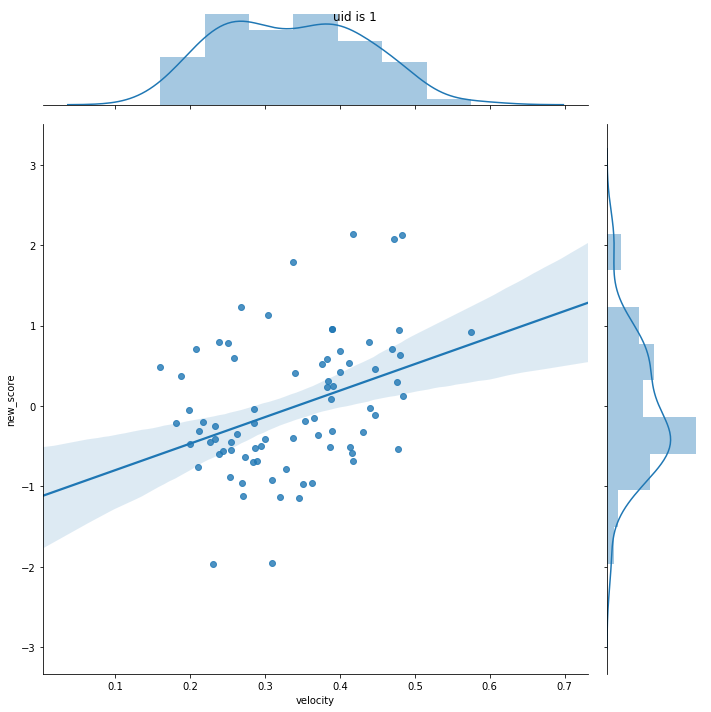

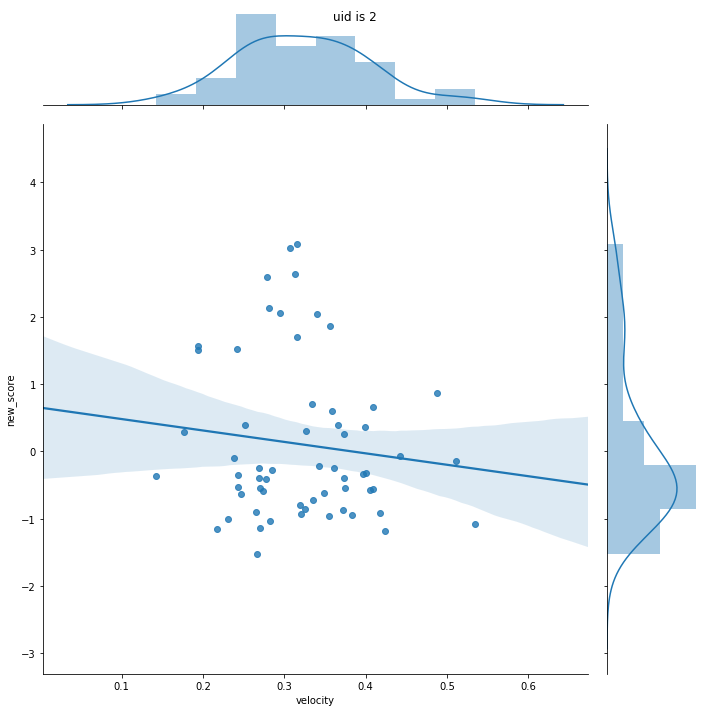

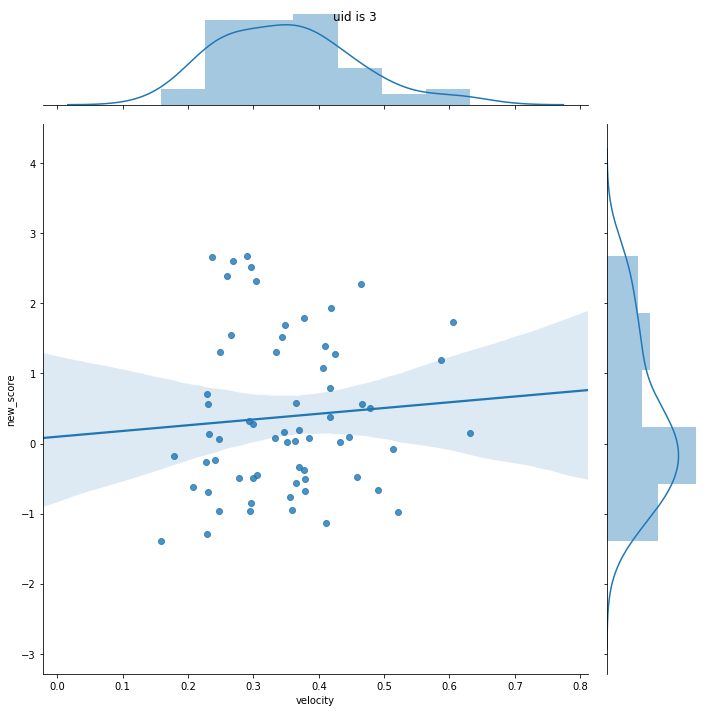

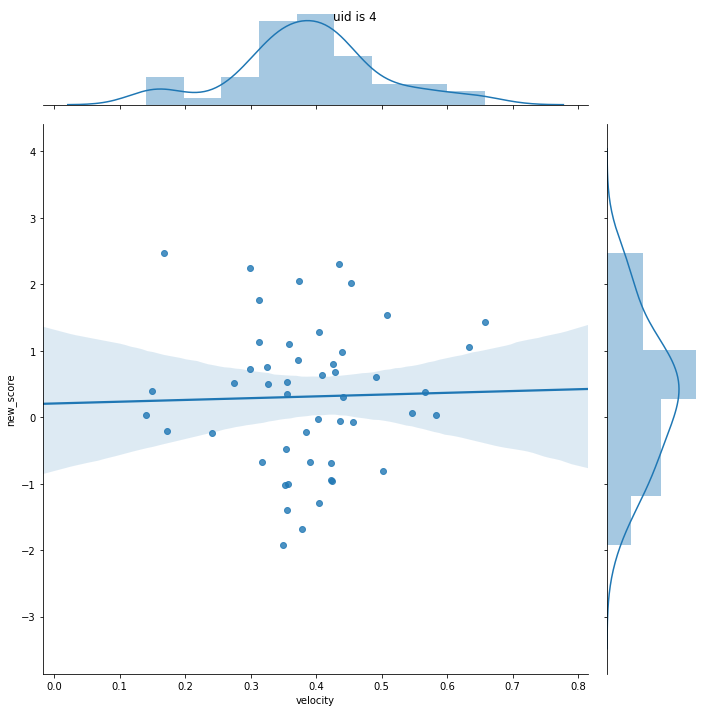

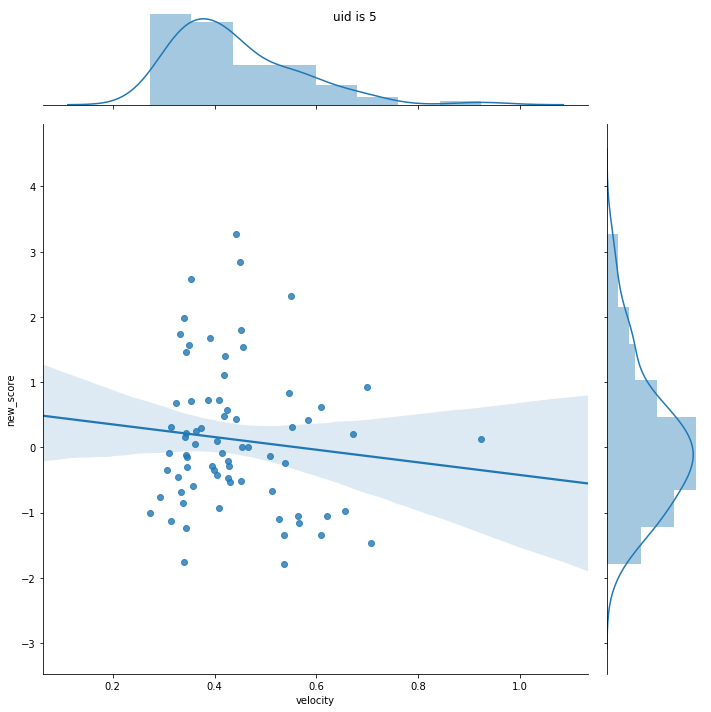

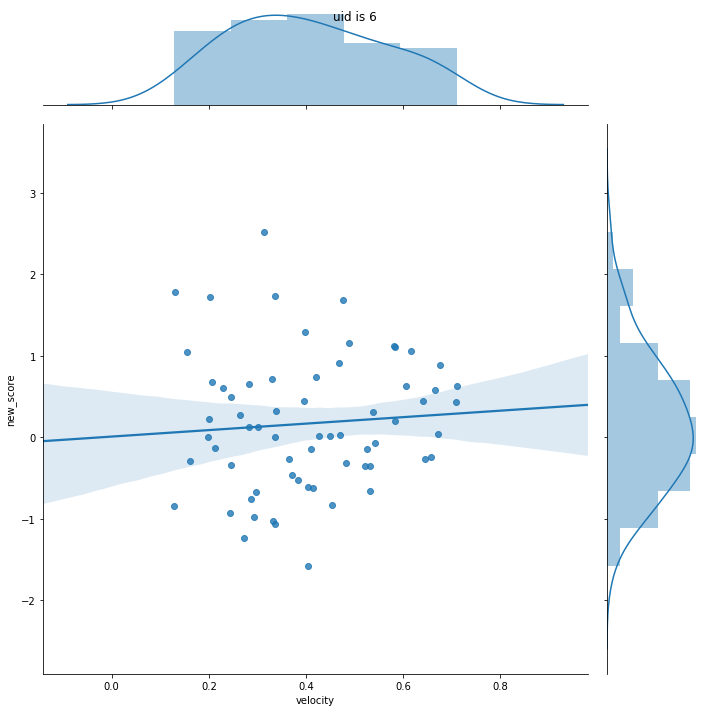

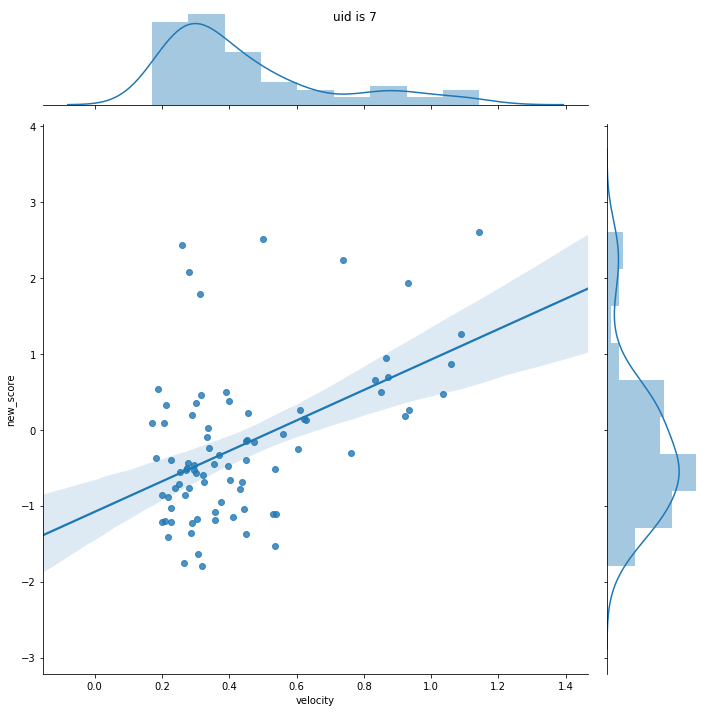

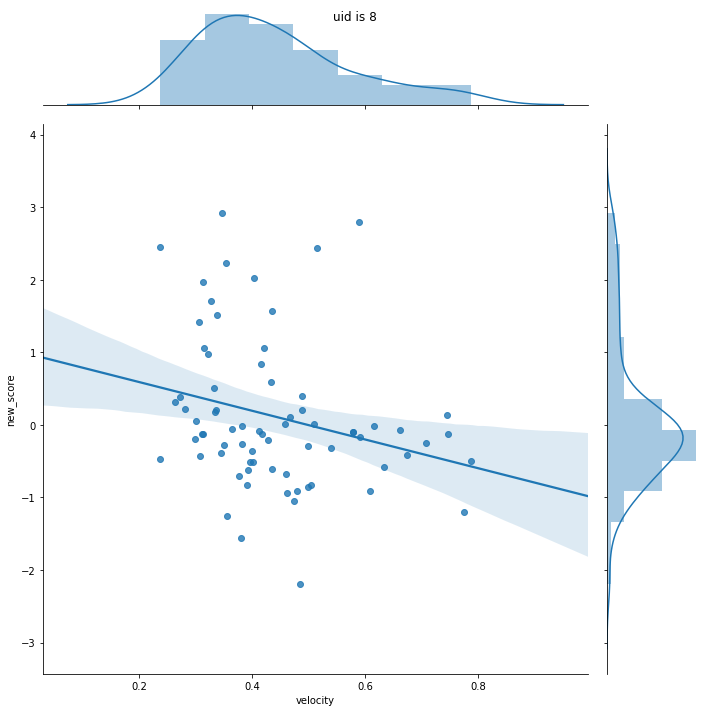

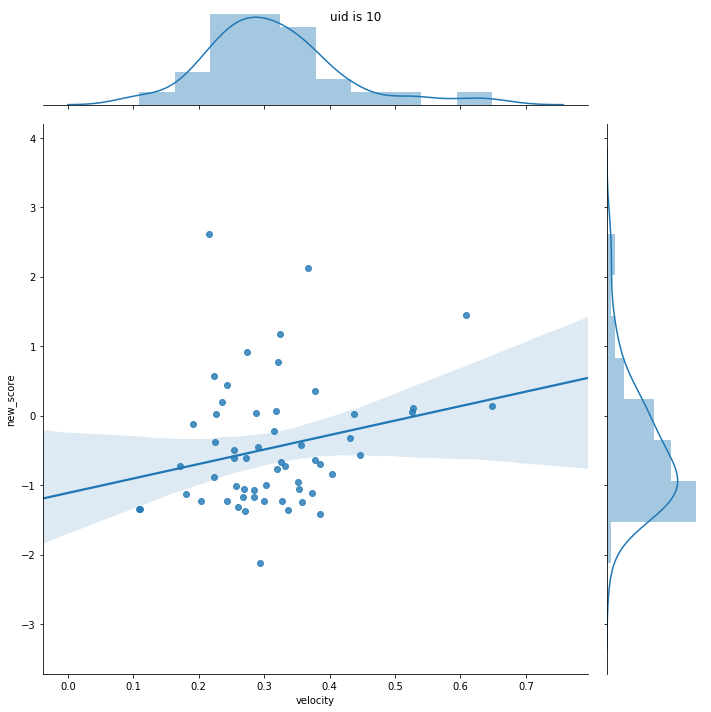

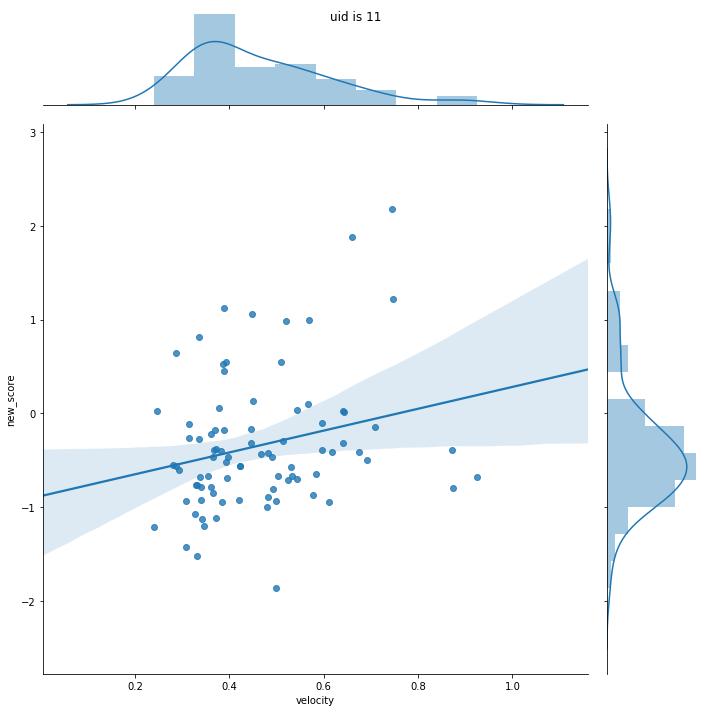

In [6]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="velocity", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

correlation between new_score and file's length (means also exercise time) 

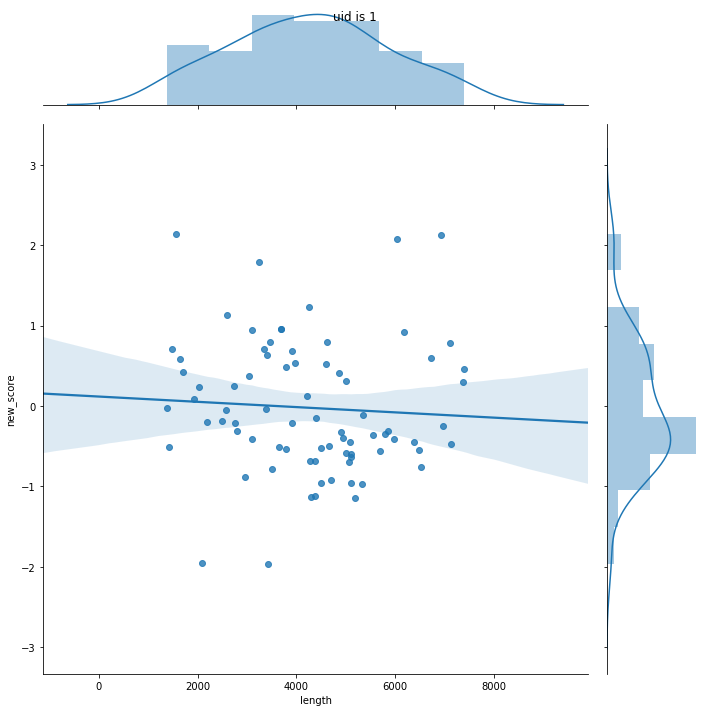

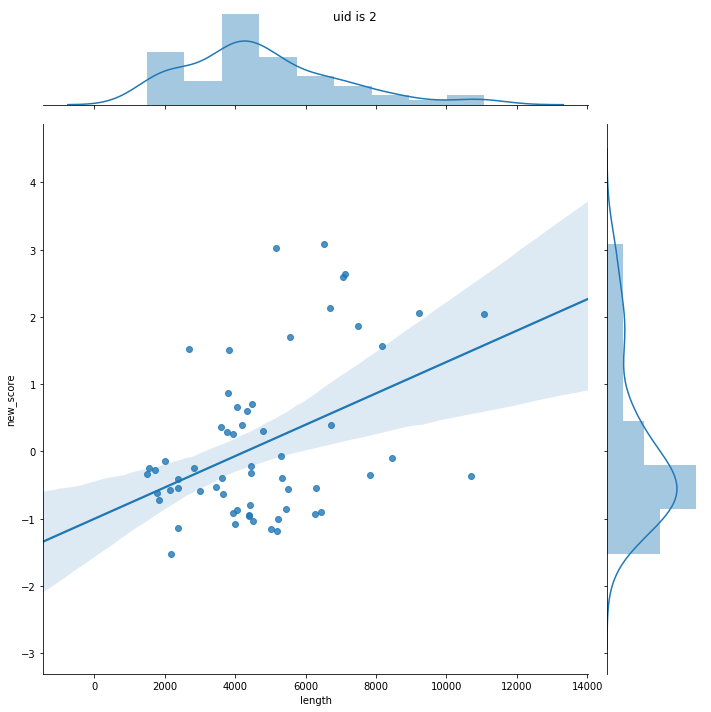

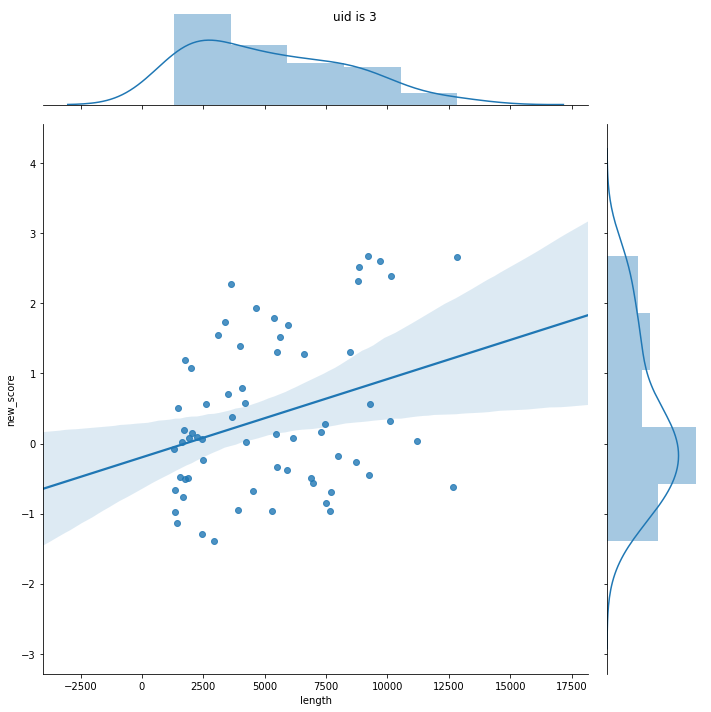

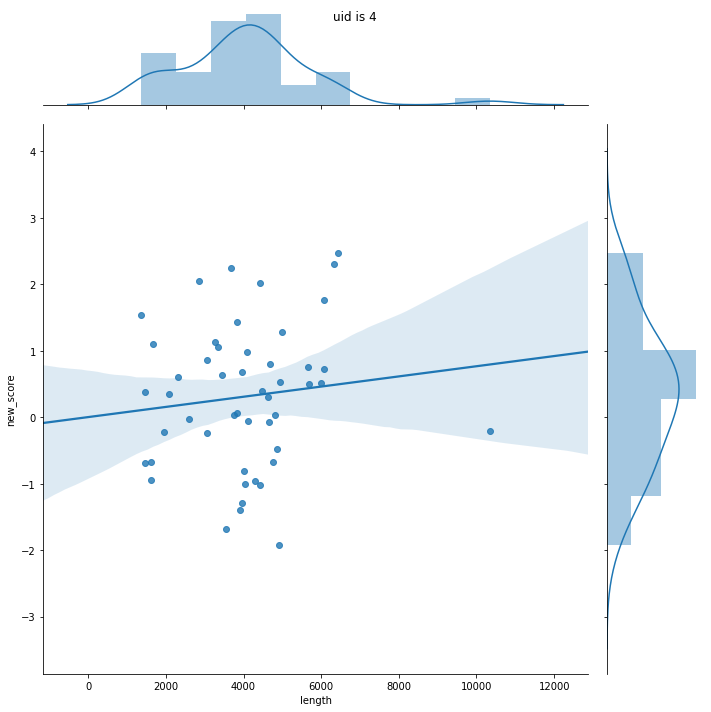

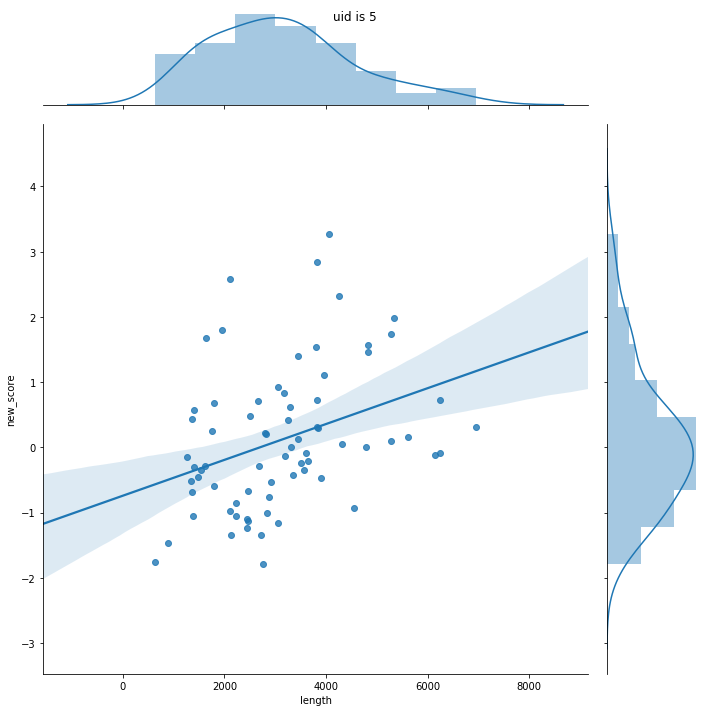

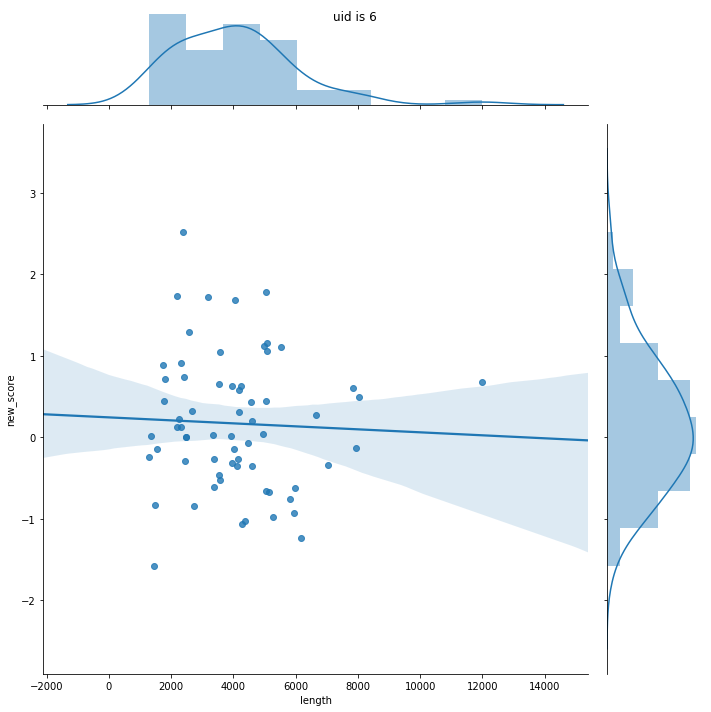

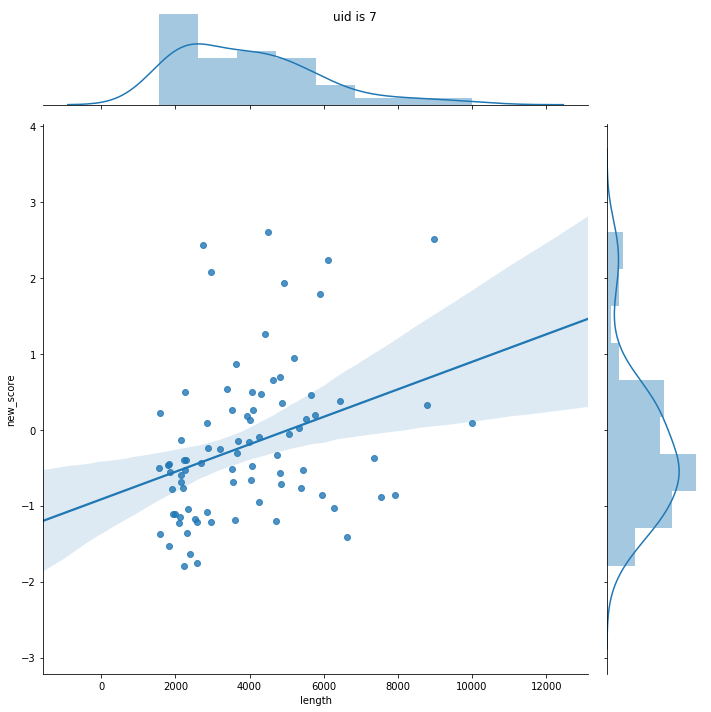

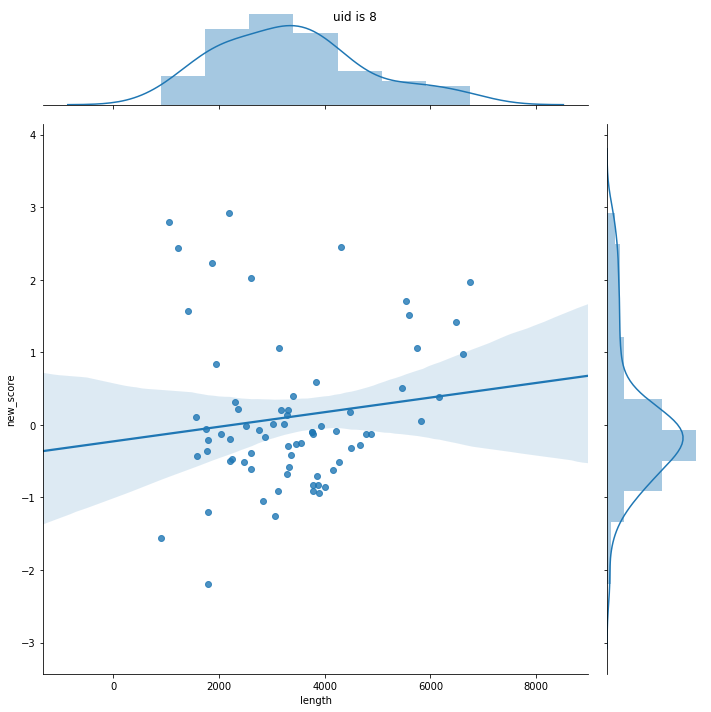

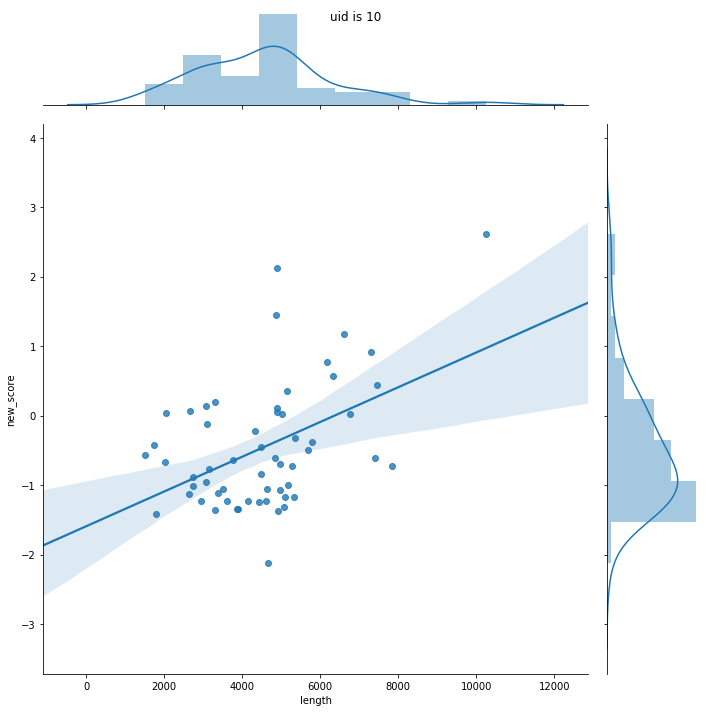

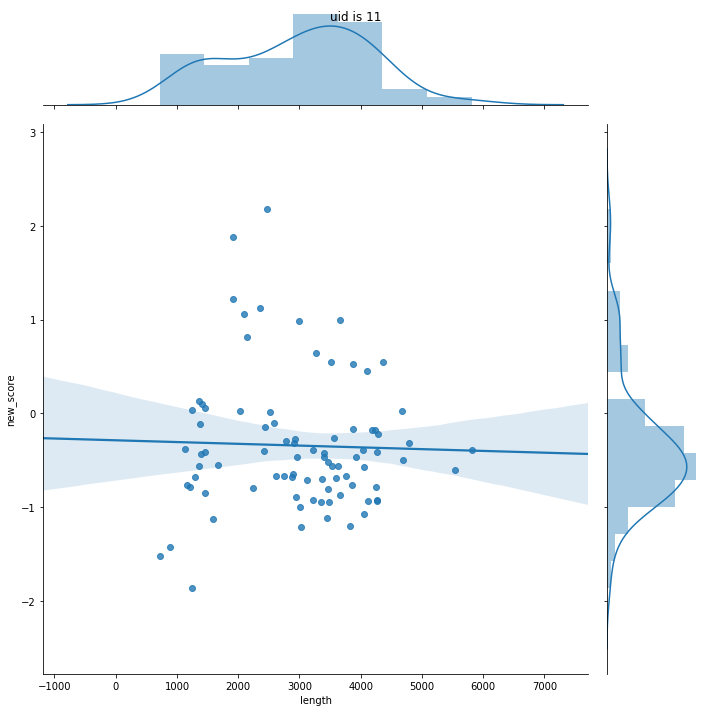

In [7]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="length", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

correlation between force and new_score 

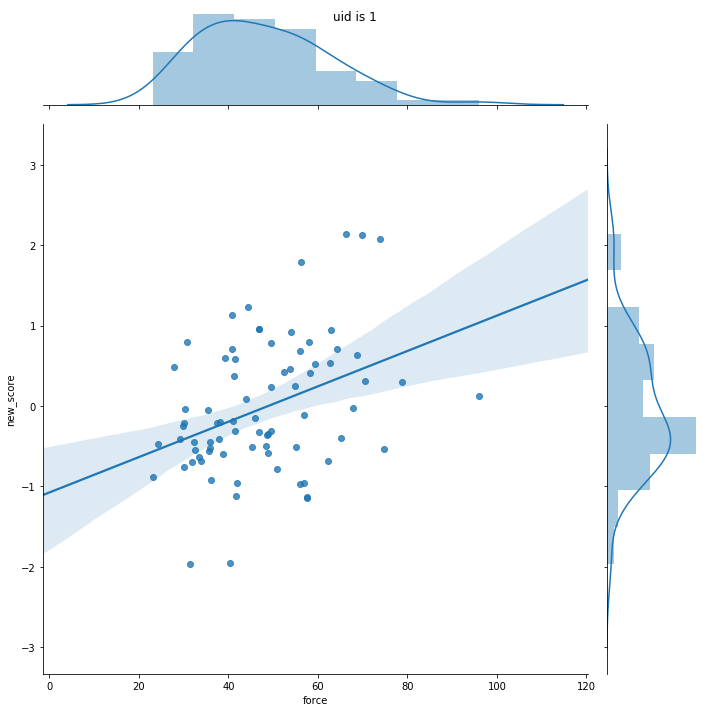

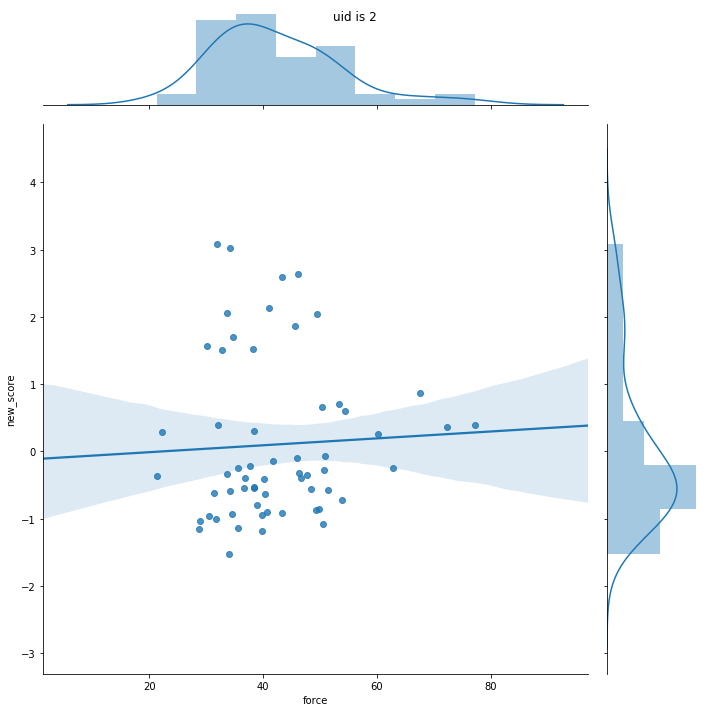

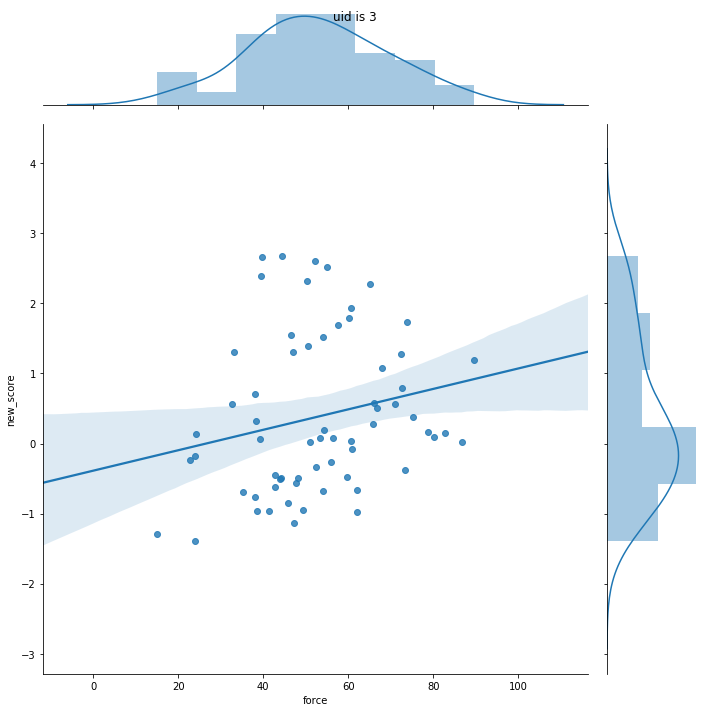

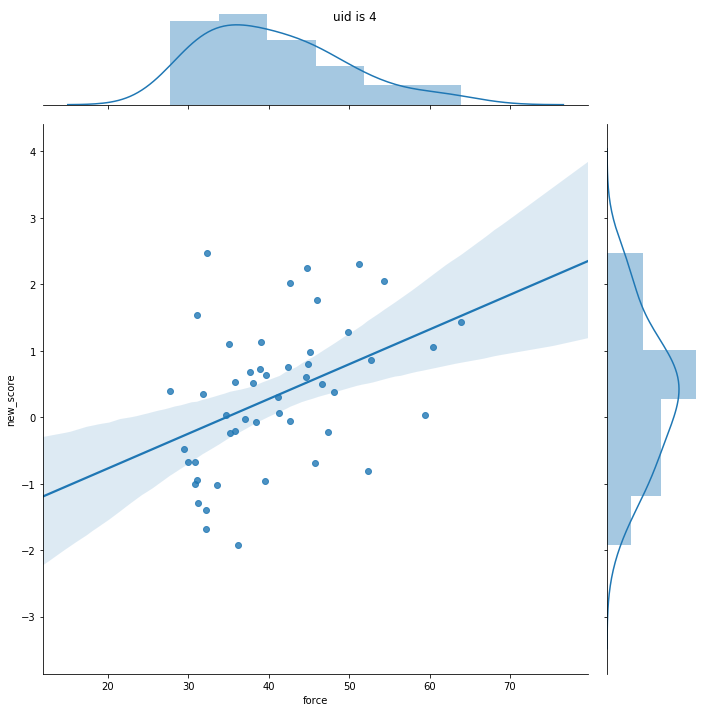

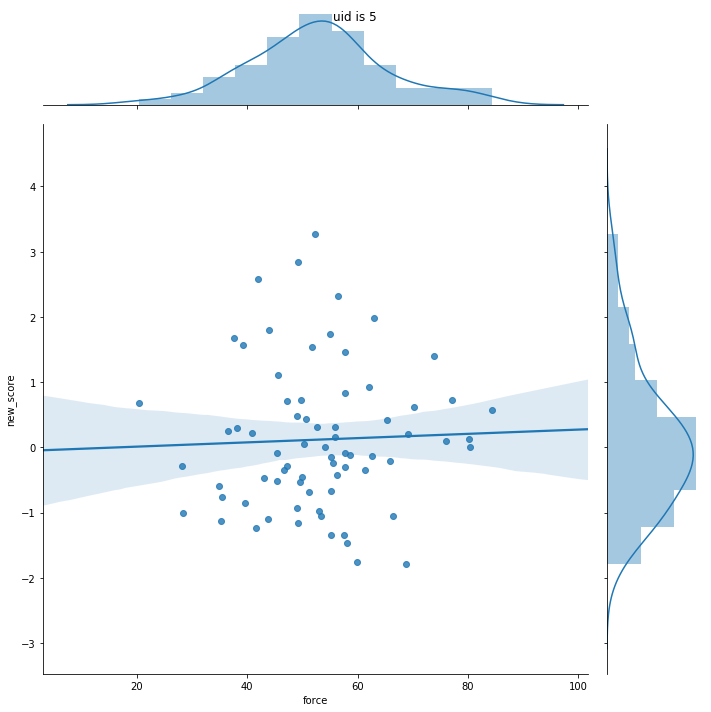

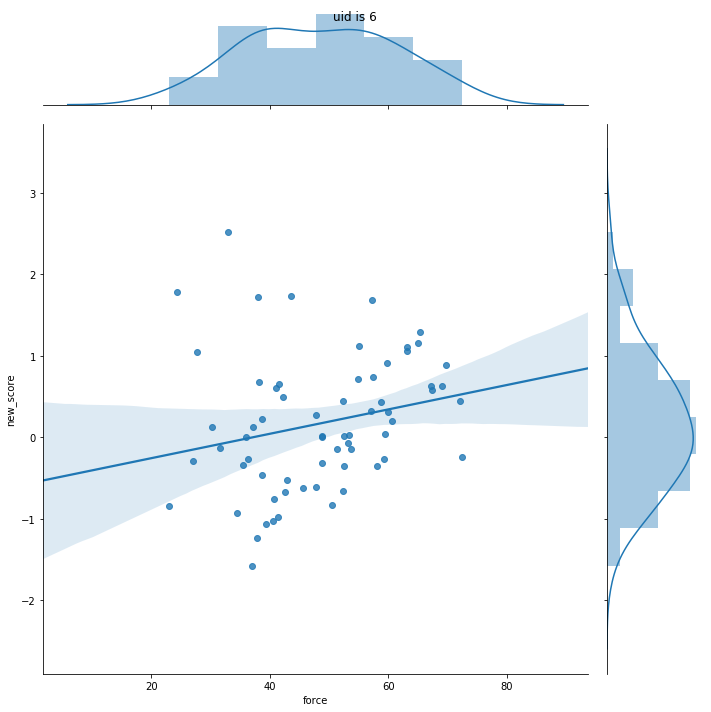

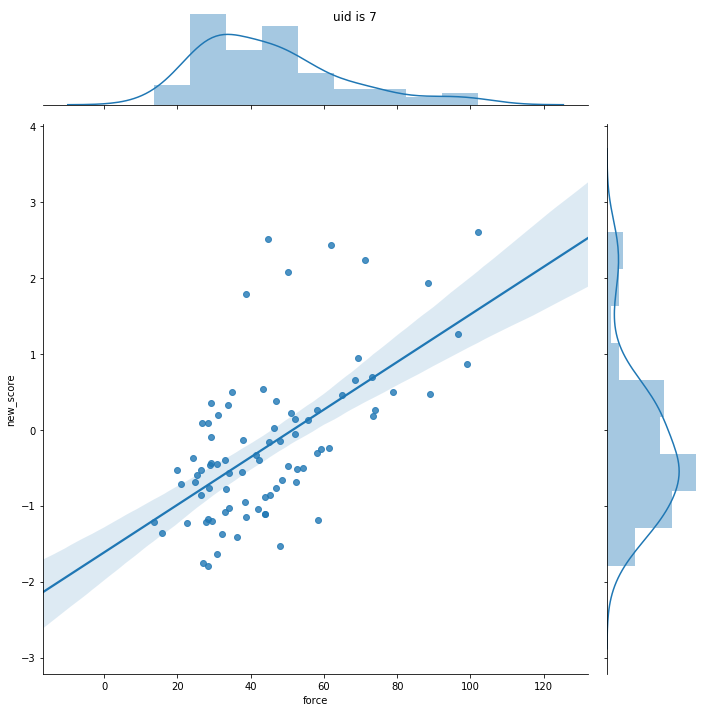

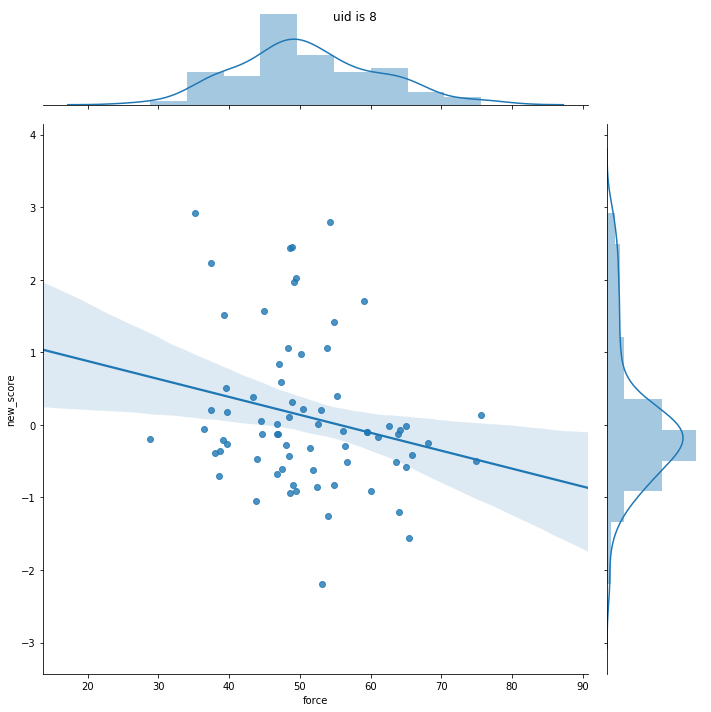

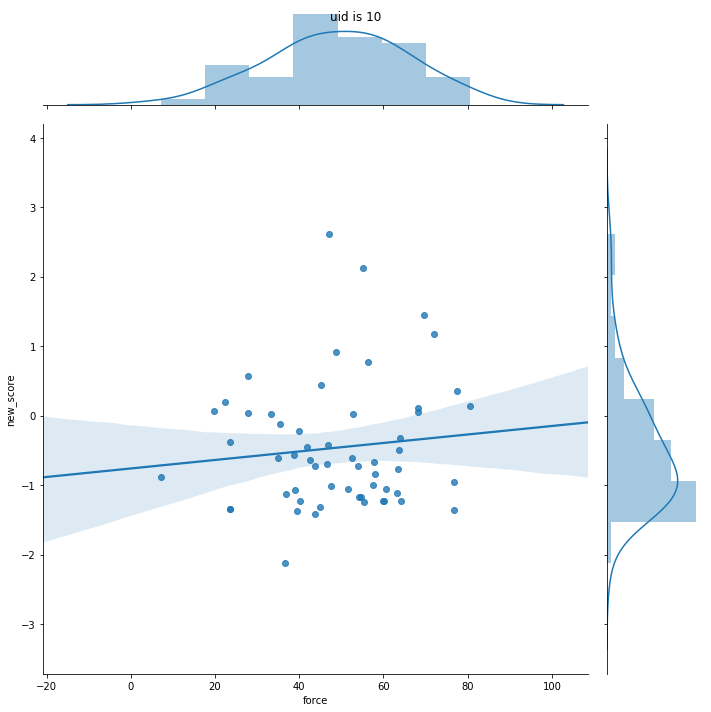

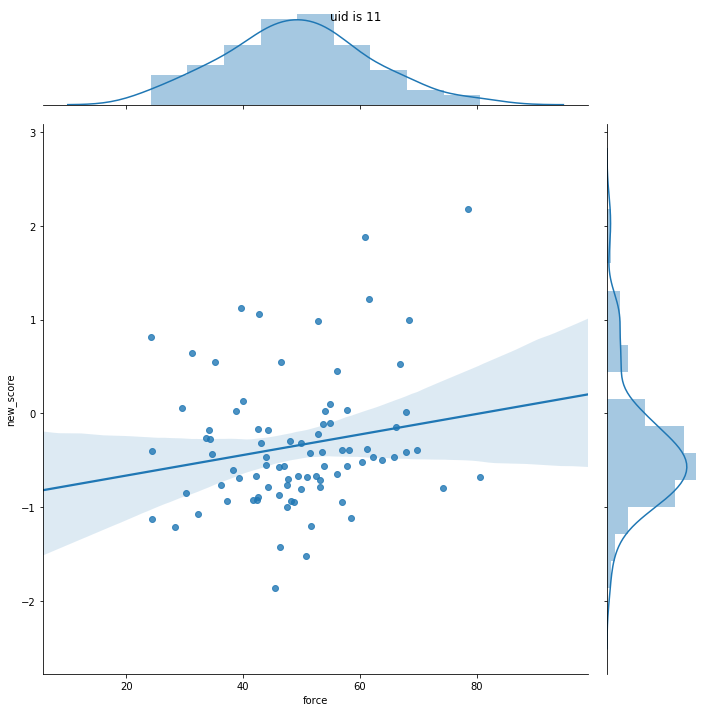

In [8]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="force", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

correlation between new_score and training day 

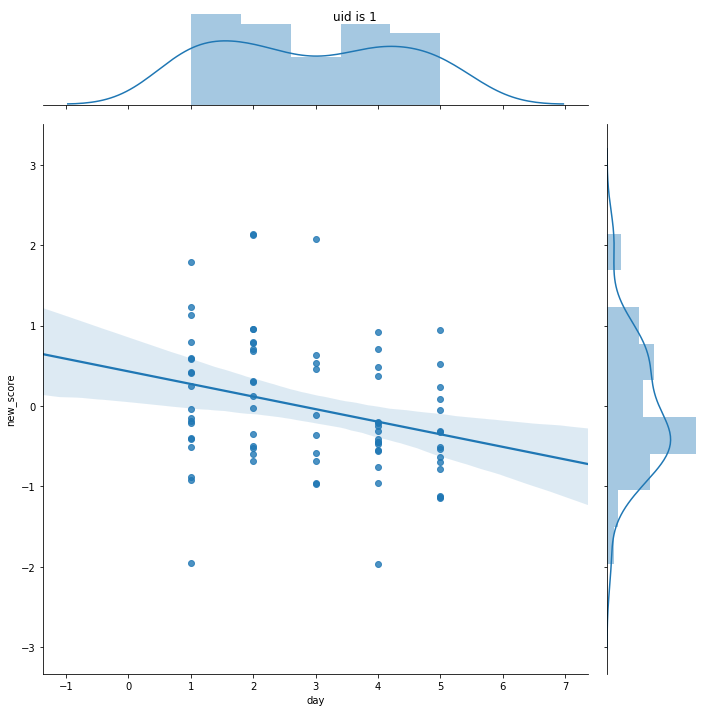

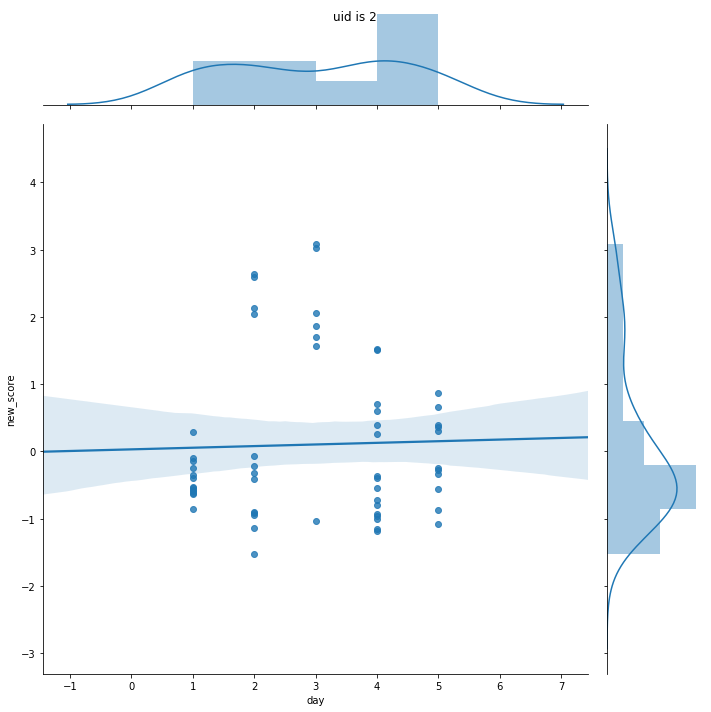

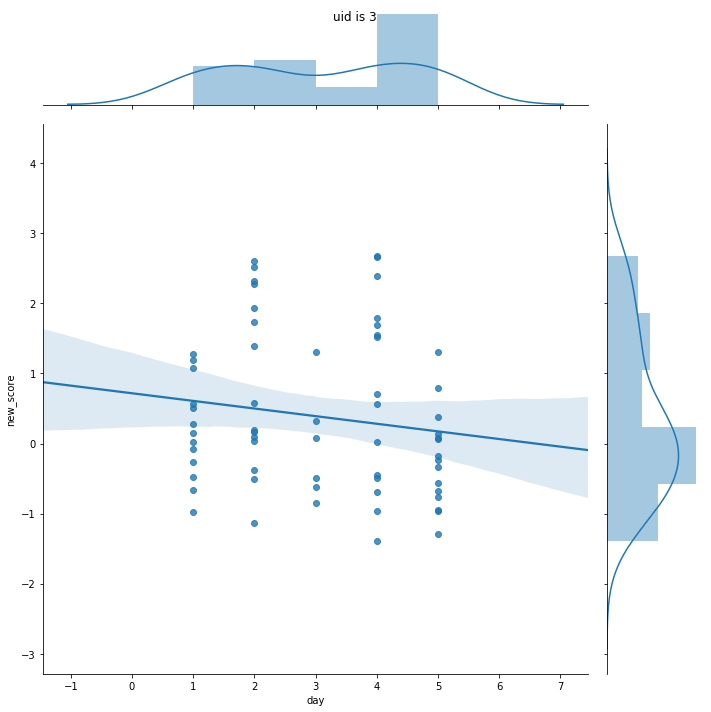

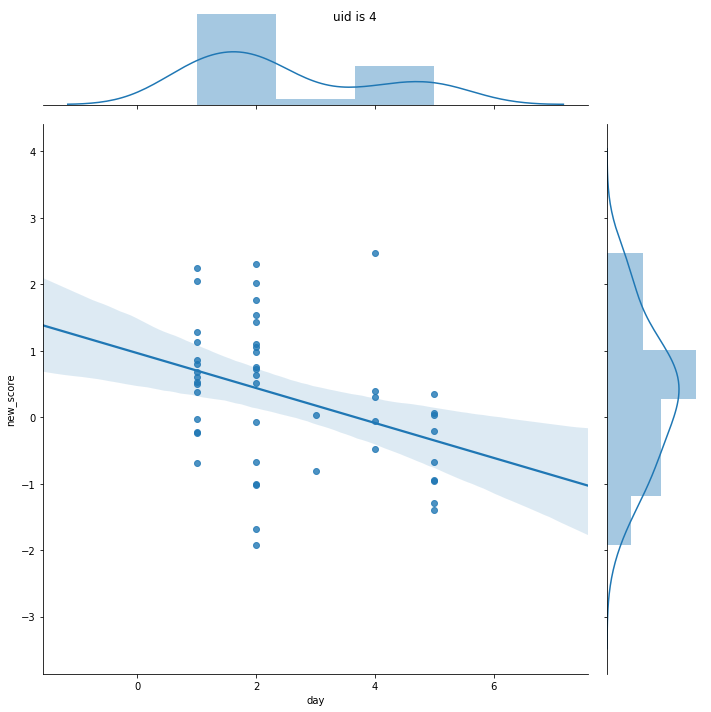

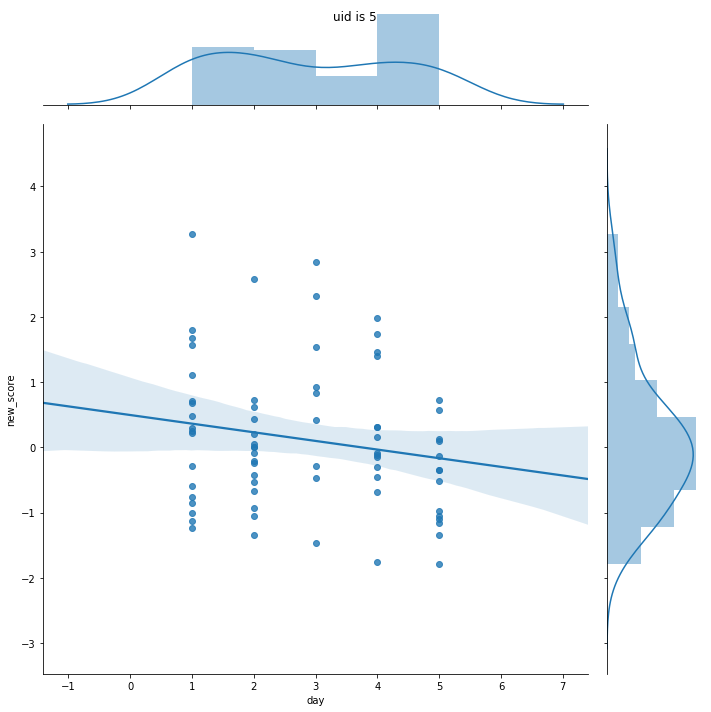

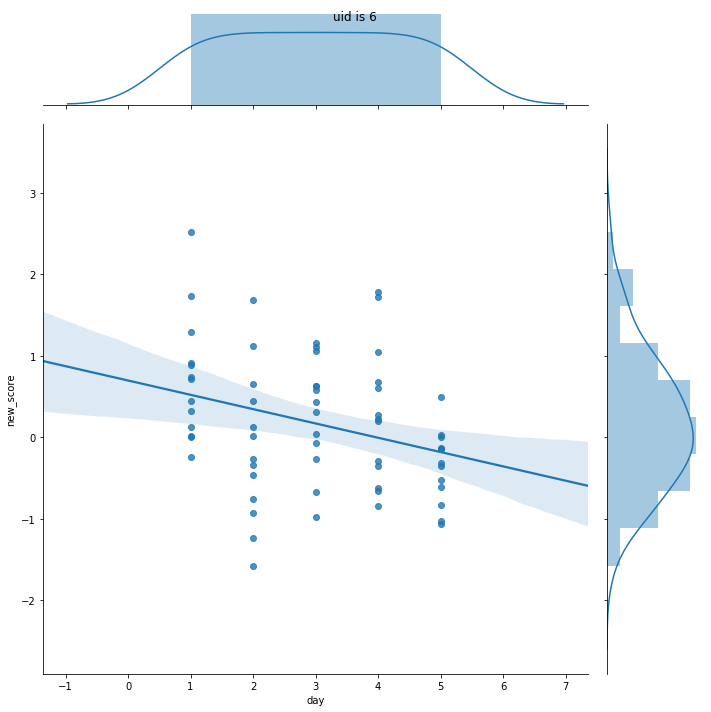

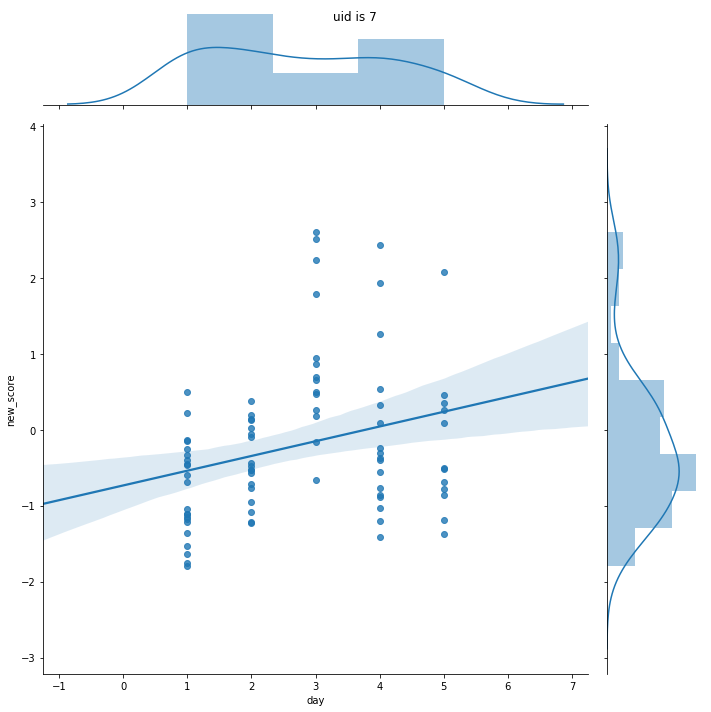

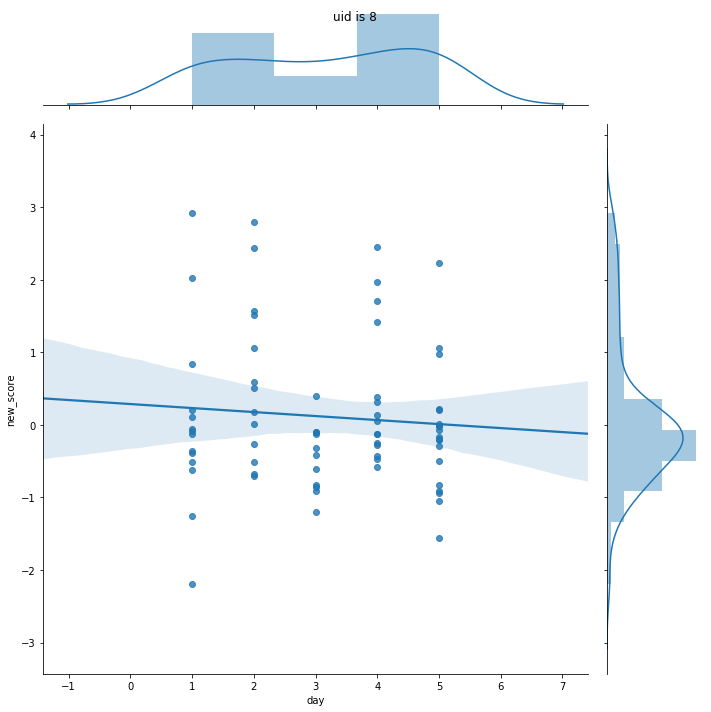

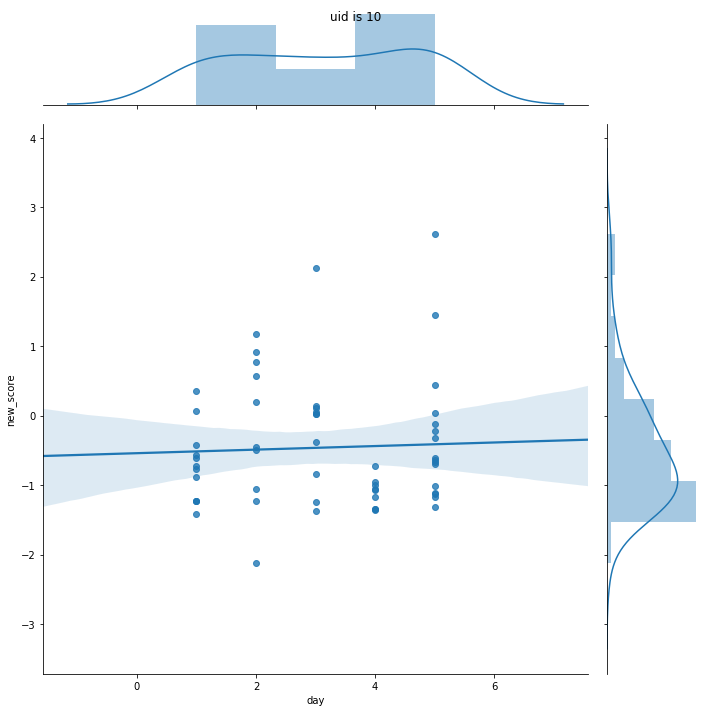

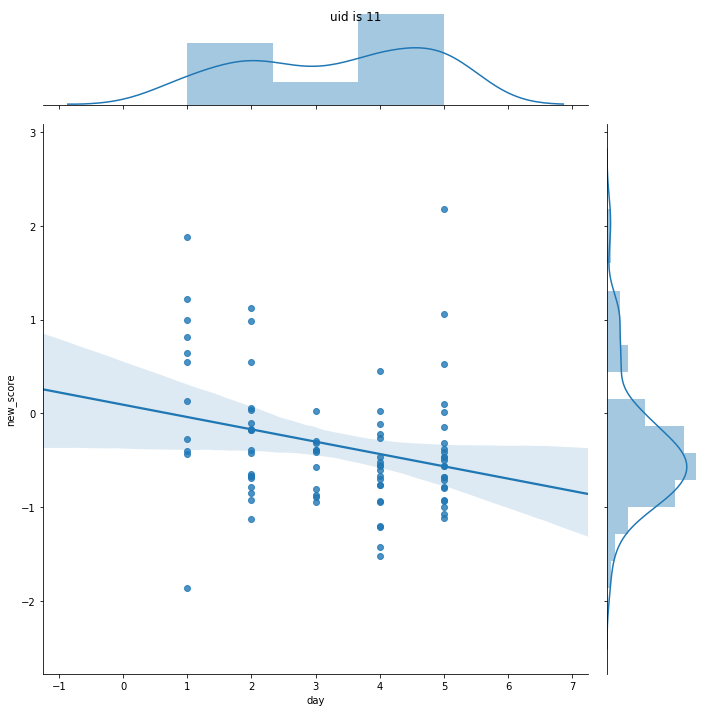

In [9]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="day", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

correlation between new_score and exc_times 

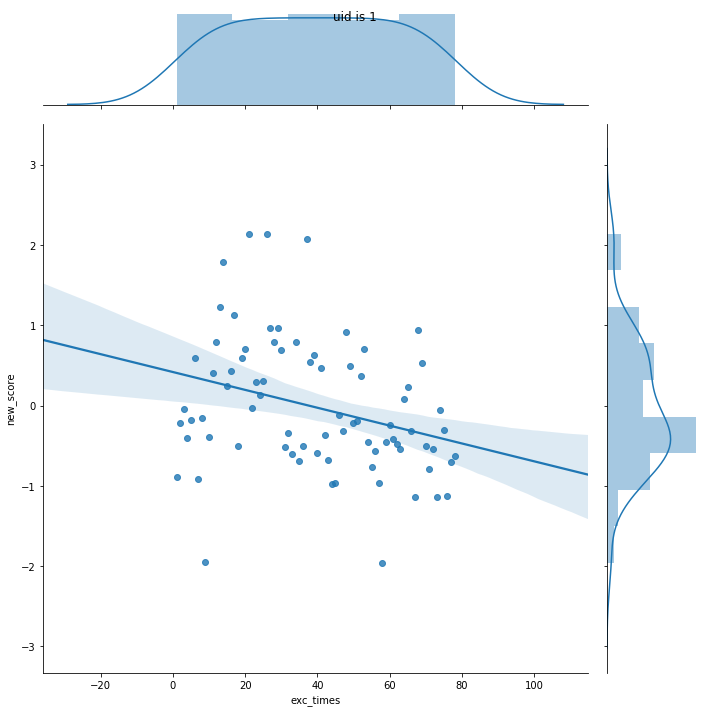

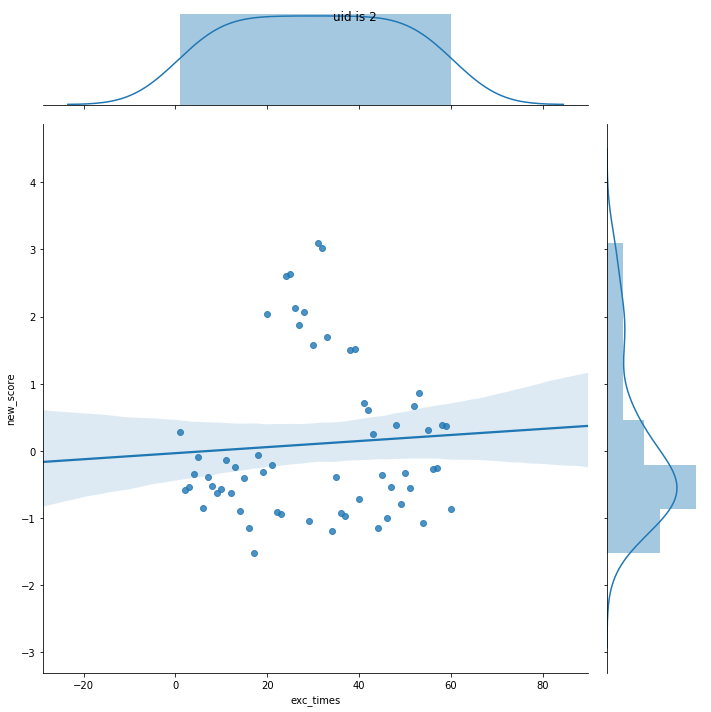

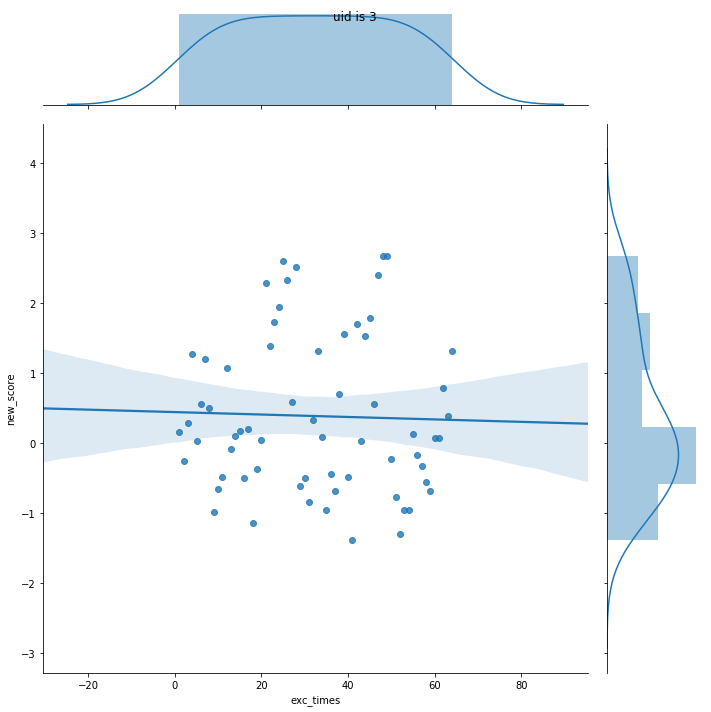

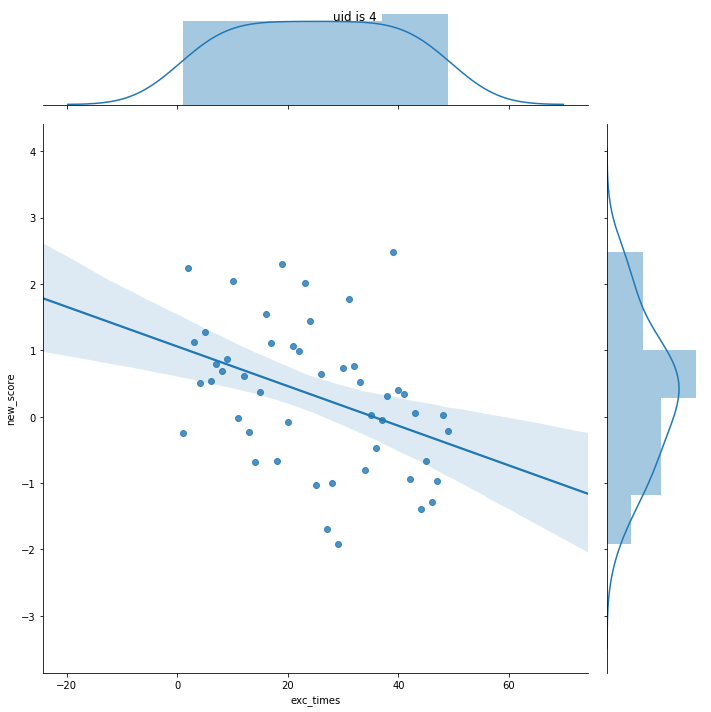

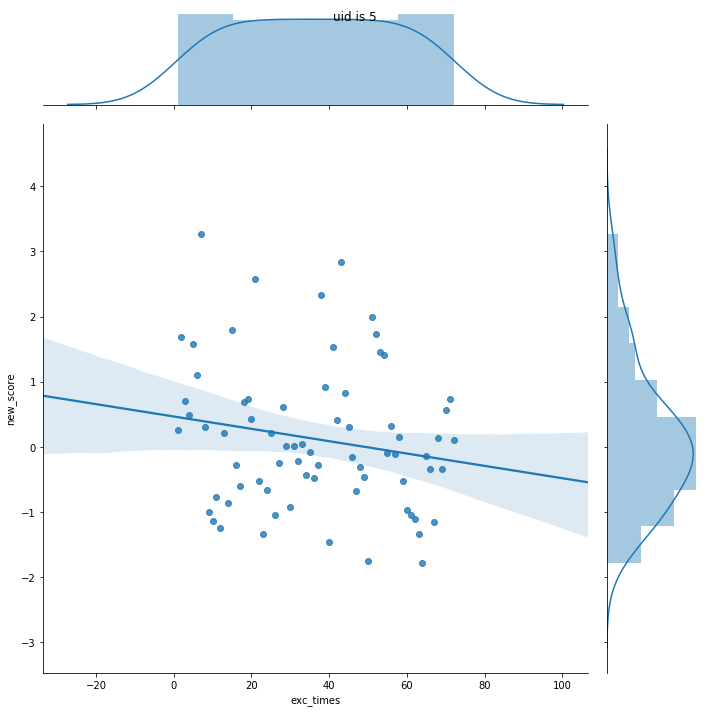

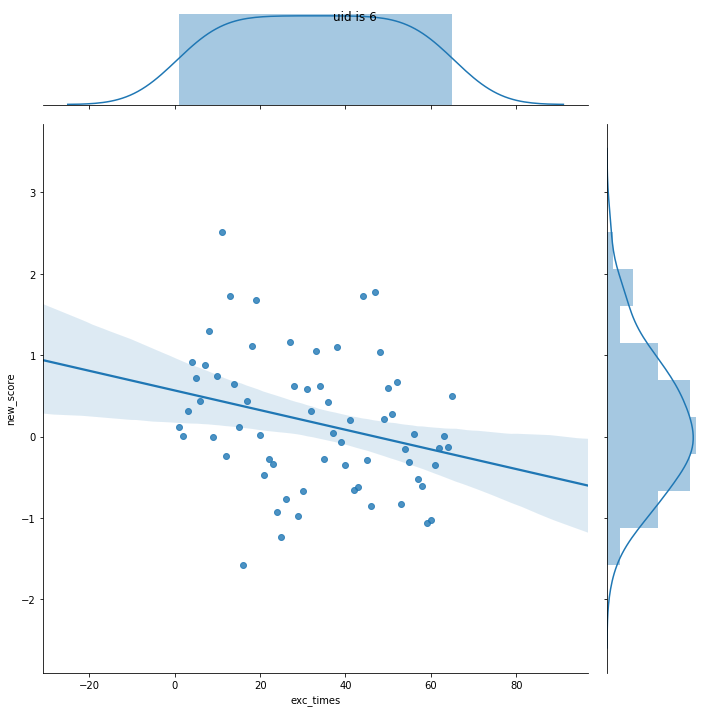

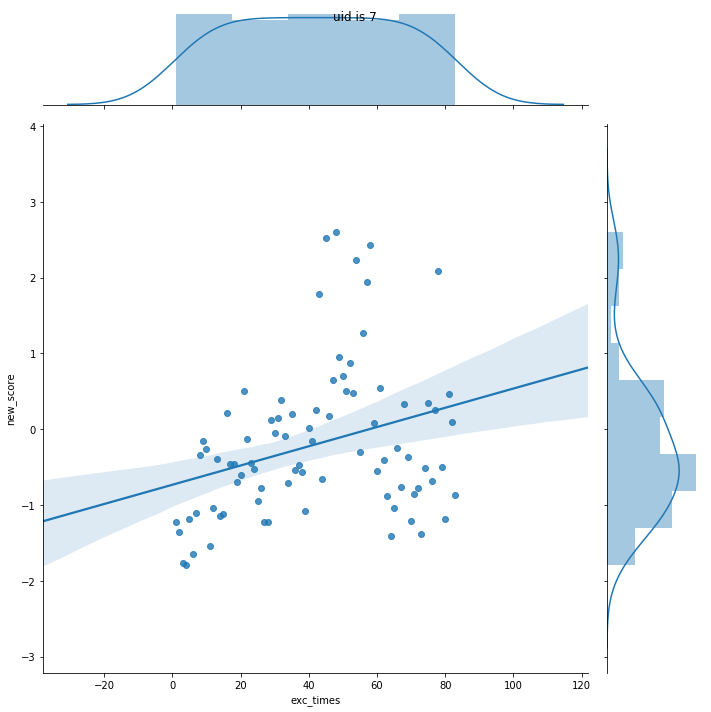

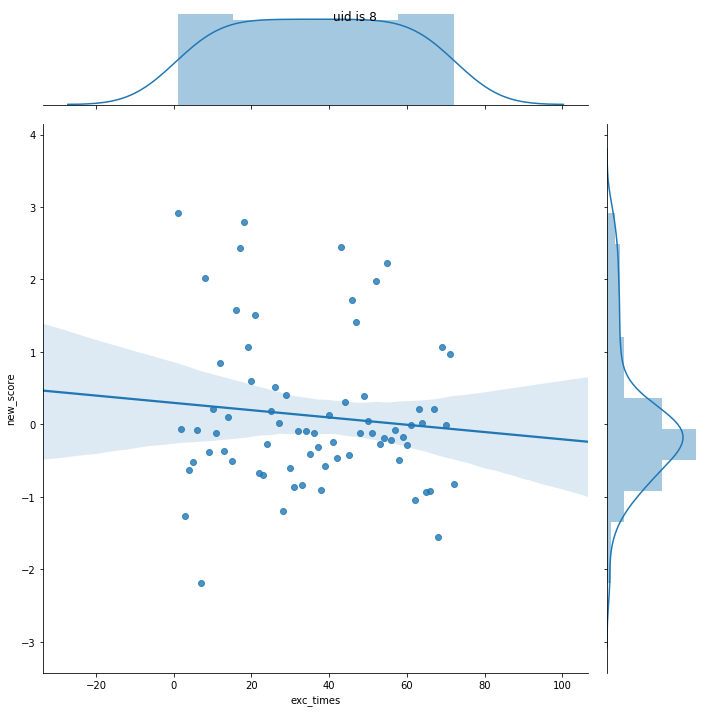

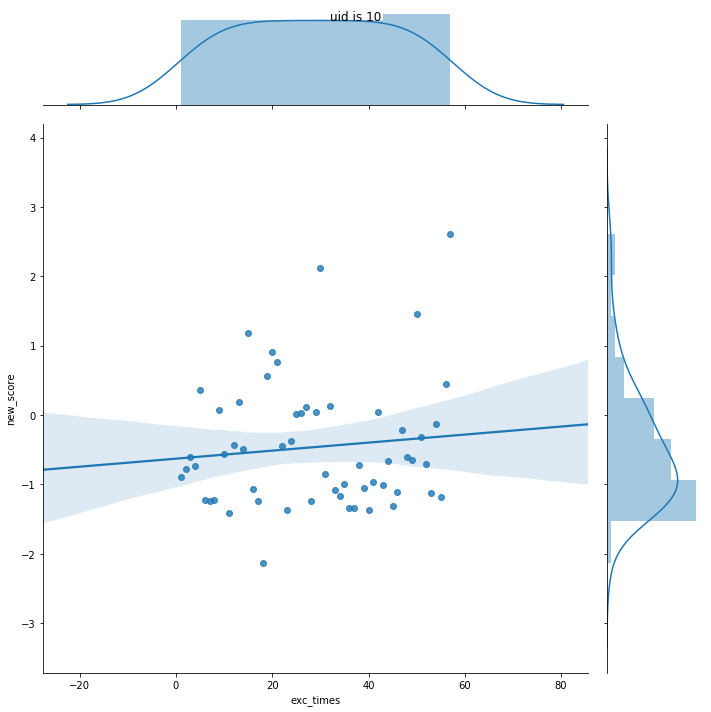

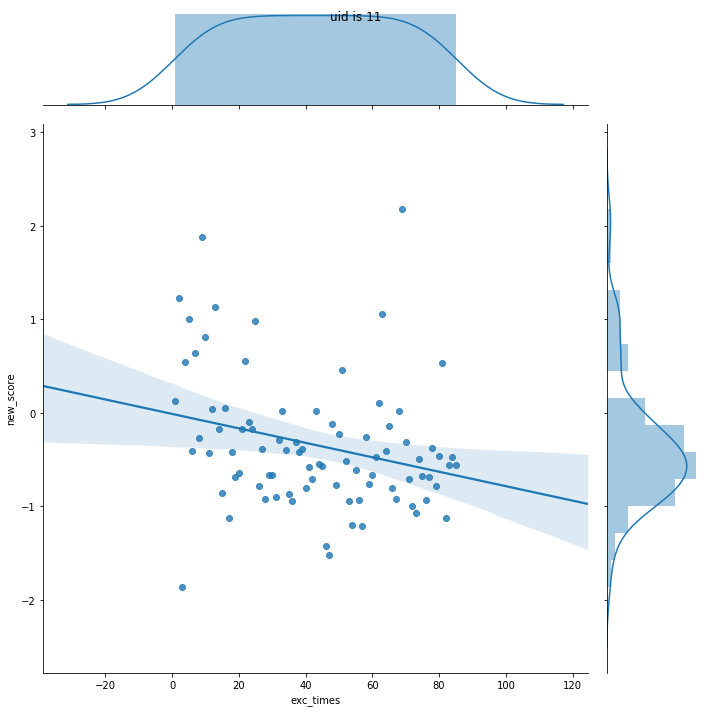

In [10]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="exc_times", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

# 3. Naive attempt, normalize all exercises' score with the same exercise number and uid <a name="naive2"></a>

### 3.1 normalize score1 with the same uid and exercise number

use dataset original_cleaned_data from 2.1 

In [11]:
cleaned_data = original_cleaned_data
cleaned_data = cleaned_data.set_index(['exc_num', 'uid'])
grouped = cleaned_data.groupby(cleaned_data.index)
for index, group in grouped:
    X_train = group['score'].as_matrix().reshape(-1, 1)
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    new_score = scaler.transform(X_train)
    cleaned_data.loc[index, 'new_score'] = new_score.T[0]
    
    
cleaned_data = cleaned_data.reset_index()
tmp = cleaned_data

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py:208: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2662: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


reorder exc_times, count all exercise in one order

In [12]:
cleaned_data = cleaned_data.set_index(['uid'])
grouped = cleaned_data.groupby(cleaned_data.index)
for index, group in grouped:
    new_order = [i+1 for i in xrange(len(group))]
    cleaned_data.loc[index, 'exc_times'] = new_order 
    
cleaned_data = cleaned_data.reset_index()
tmp = cleaned_data[['uid', 'day', 'exc_times', 'velocity', 'length', 'force', 'new_score']]
tmp.head()

uid  day  exc_times  velocity  length      force  new_score
0  1.0  1.0        1.0  0.252595  2955.0  23.072412   0.000000
1  1.0  1.0        2.0  0.285011  3903.0  37.559940  -0.005003
2  1.0  1.0        3.0  0.284888  3383.0  30.321137   1.302312
3  1.0  1.0        4.0  0.299663  3102.0  37.960616  -1.503773
4  1.0  1.0        5.0  0.353186  2490.0  40.989272   0.206464

### 3.2 Correlation analysis

Correlation between new_socre and velocity 

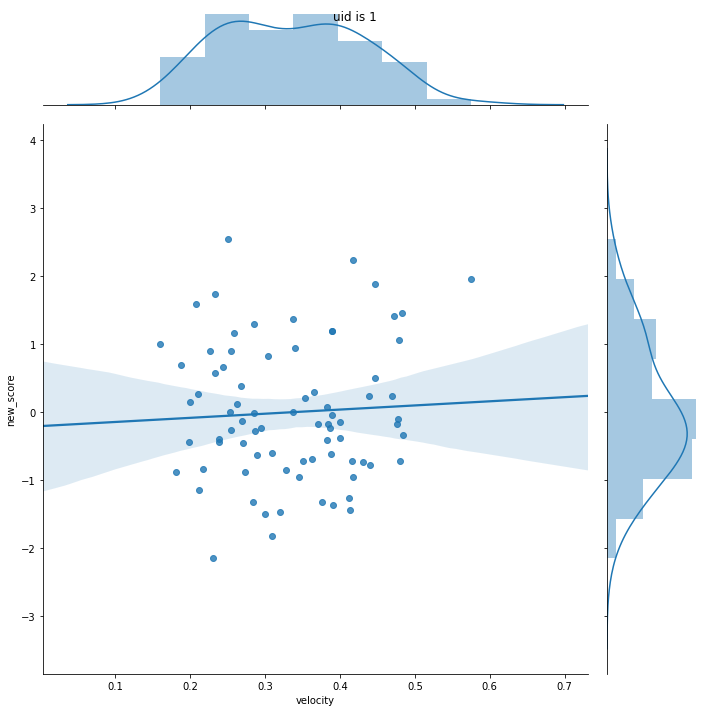

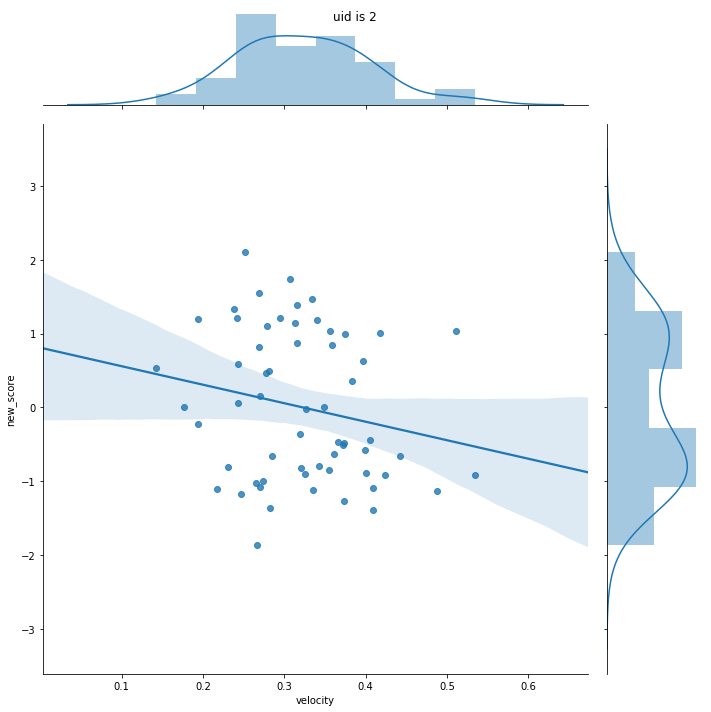

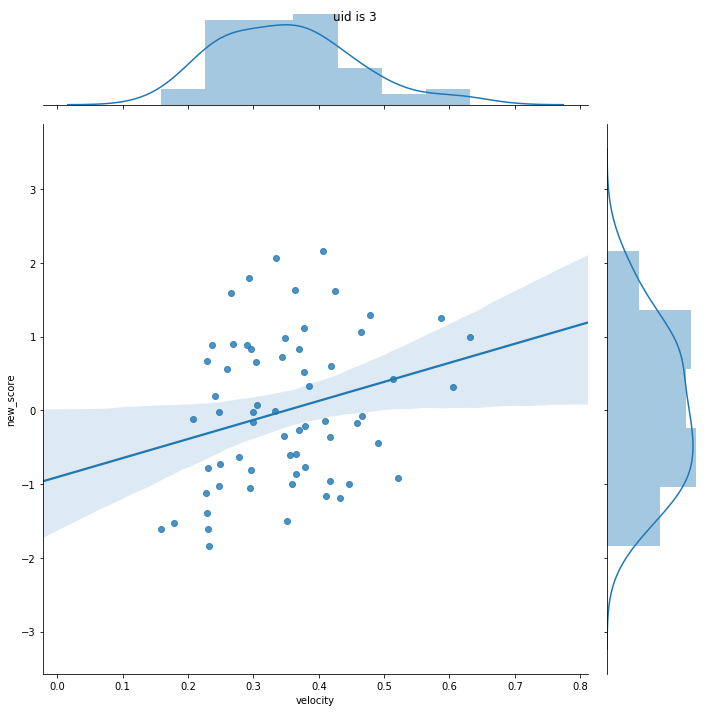

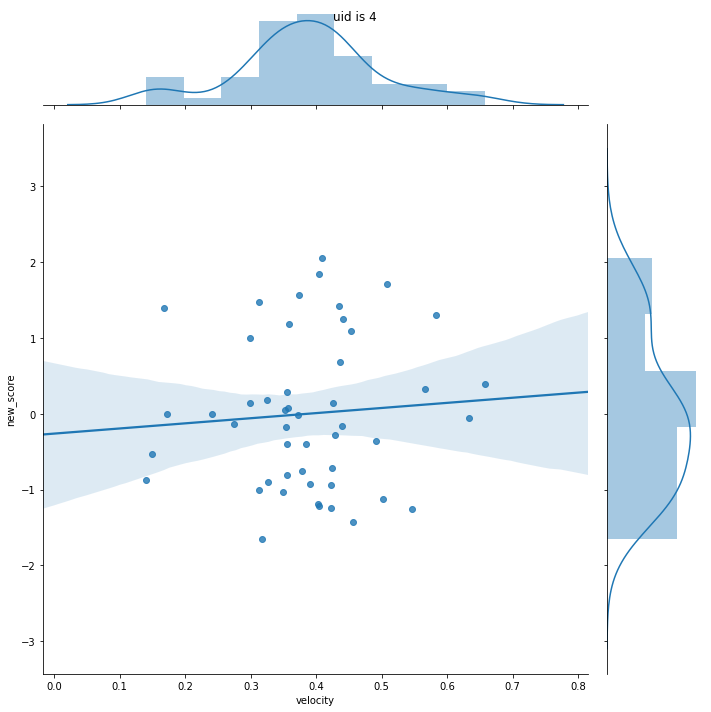

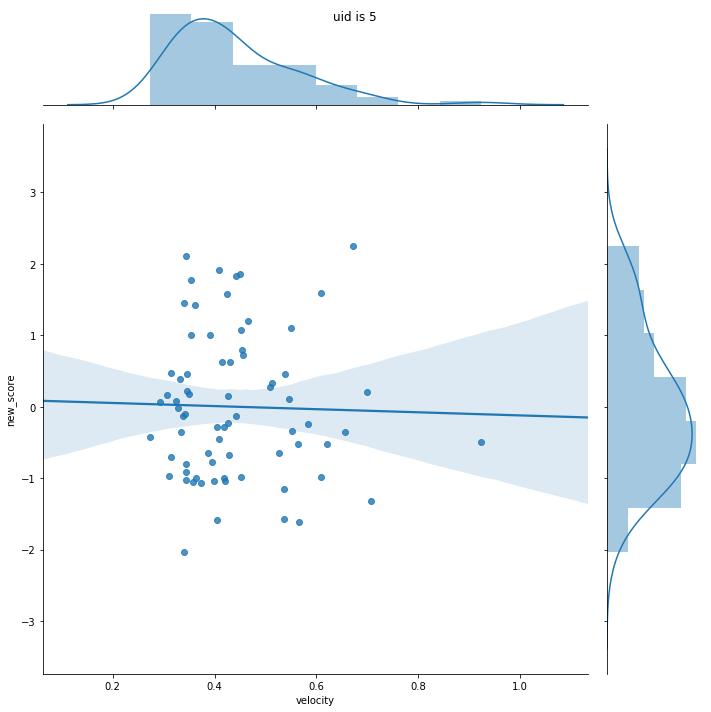

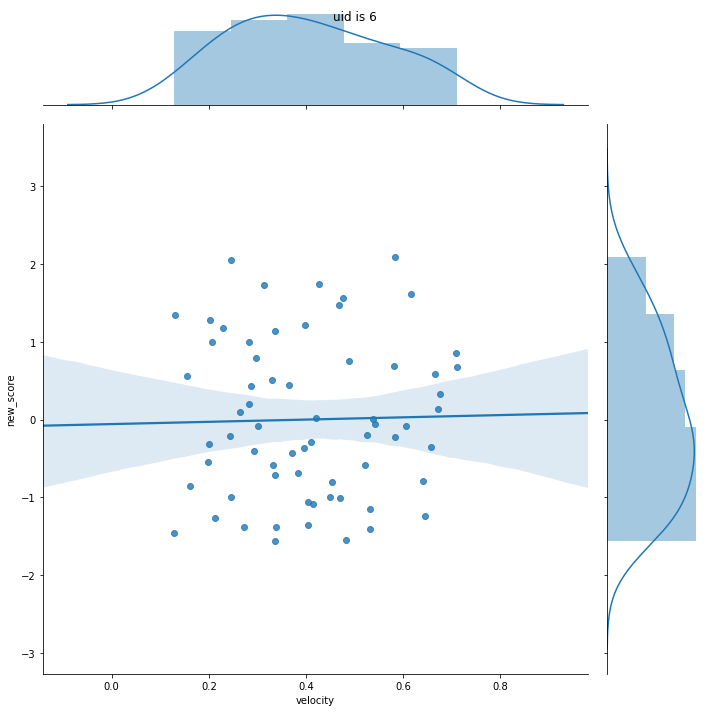

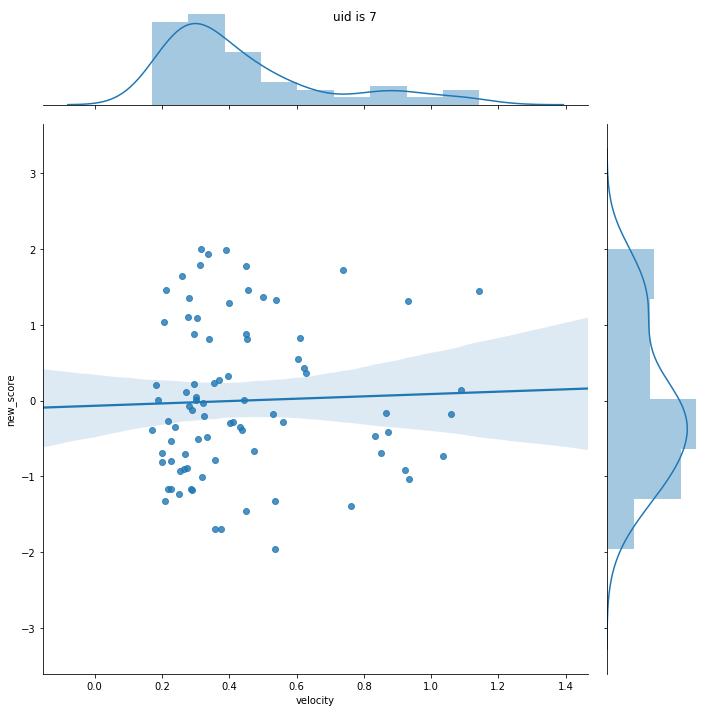

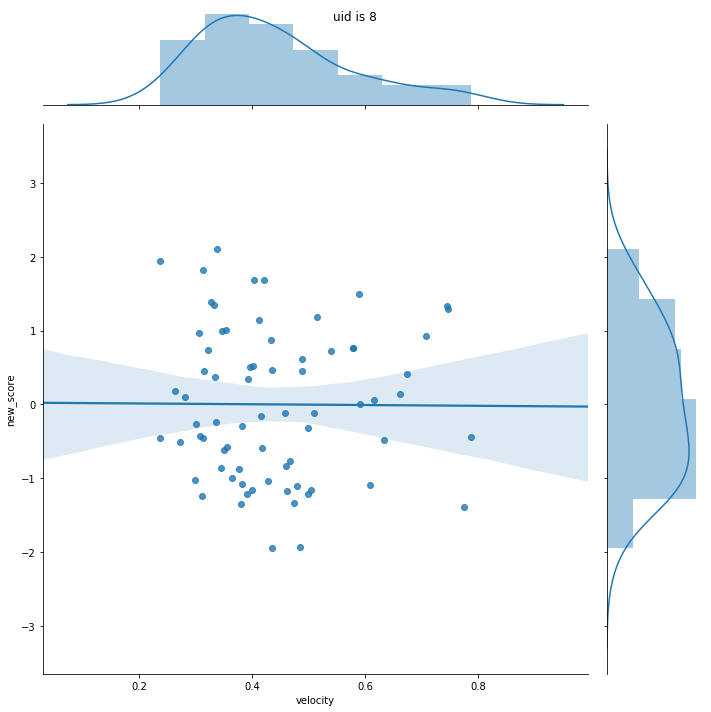

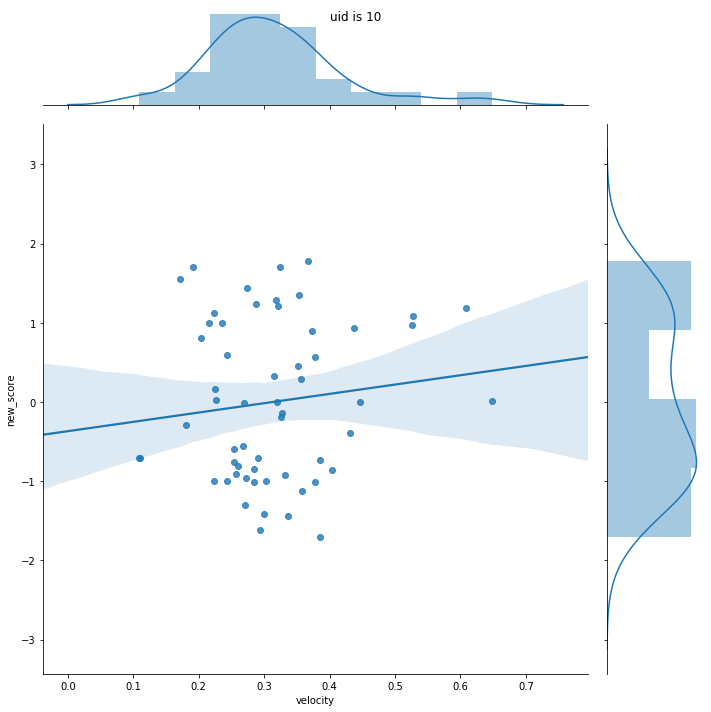

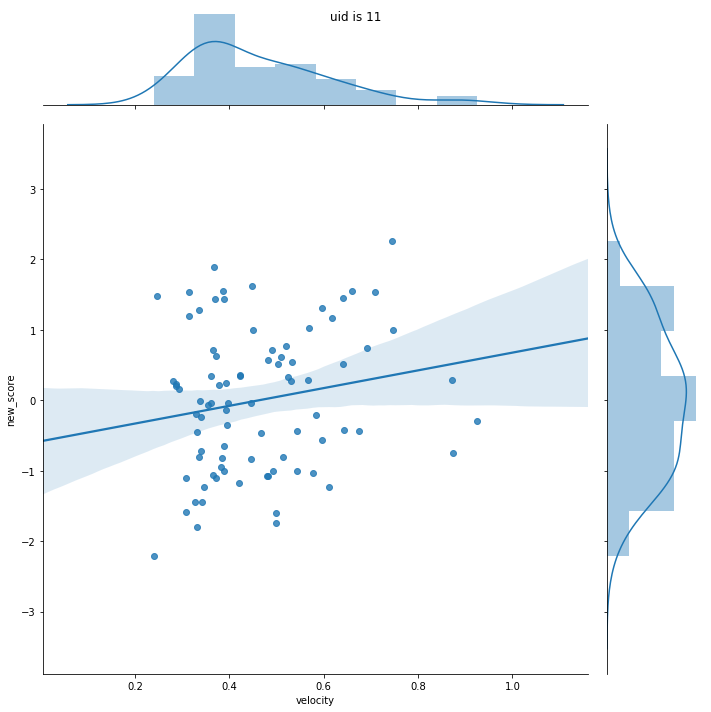

In [13]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="velocity", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

correlation between new_score and file's length (means also exercise time) 

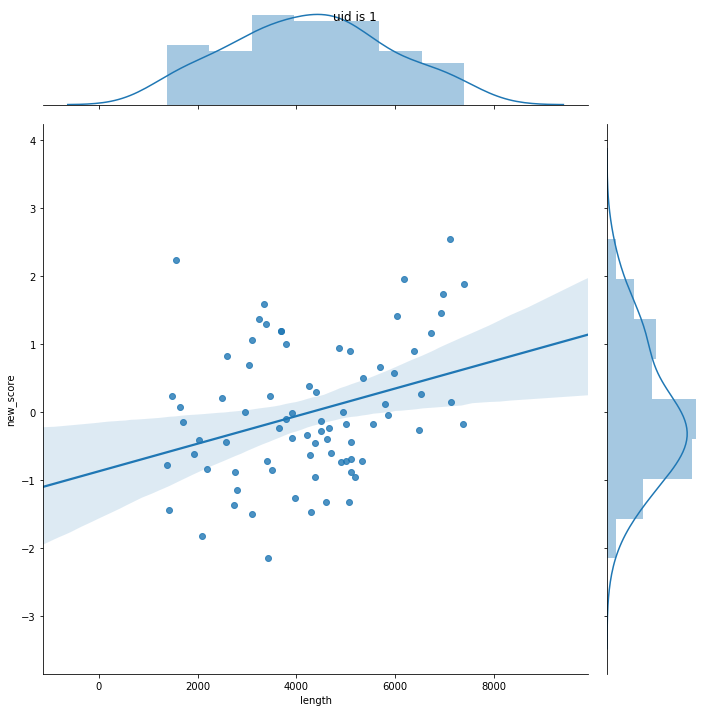

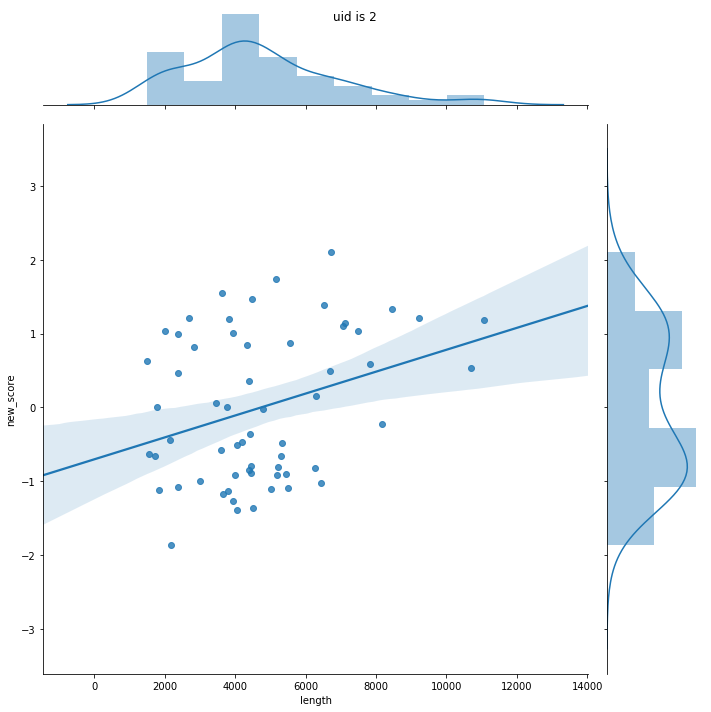

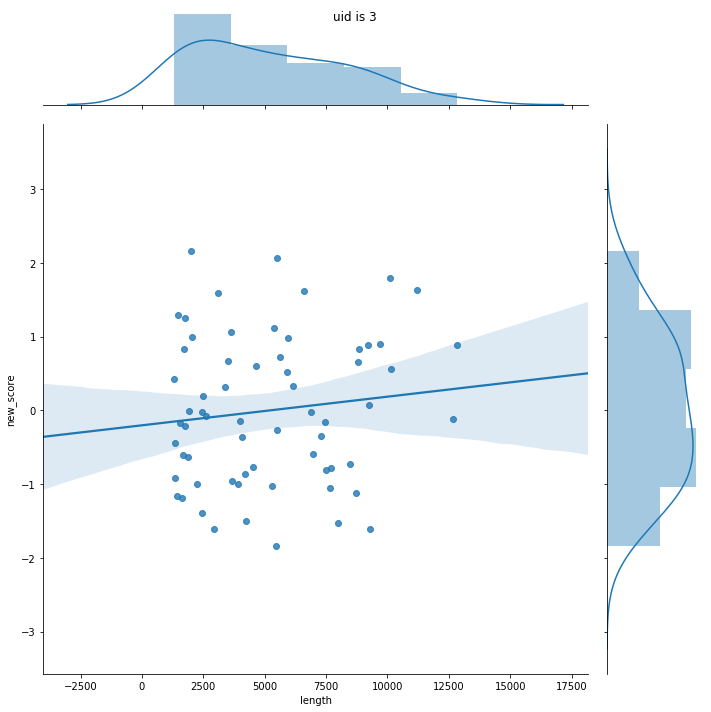

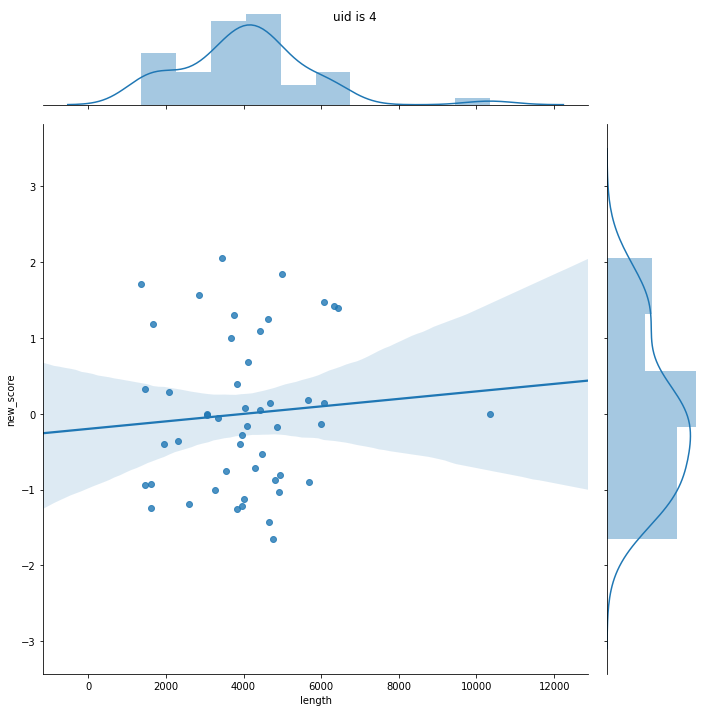

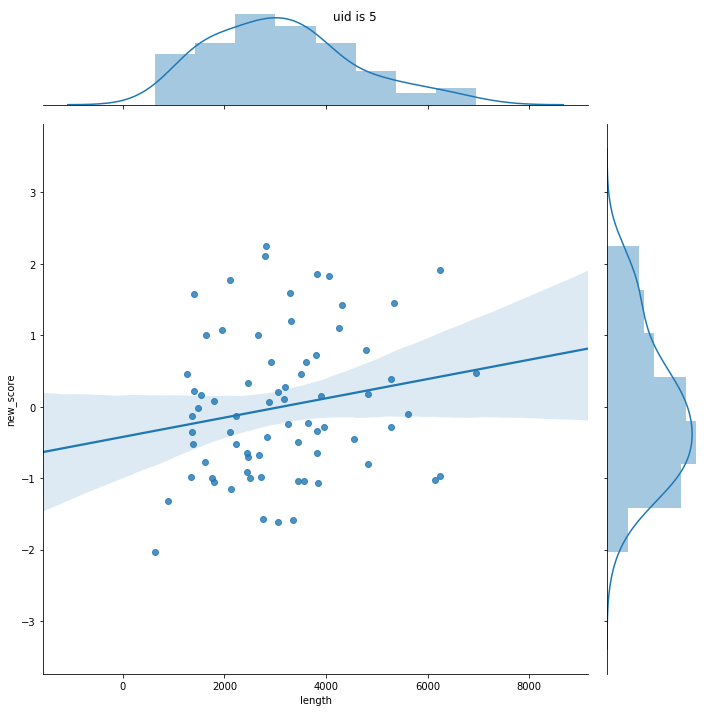

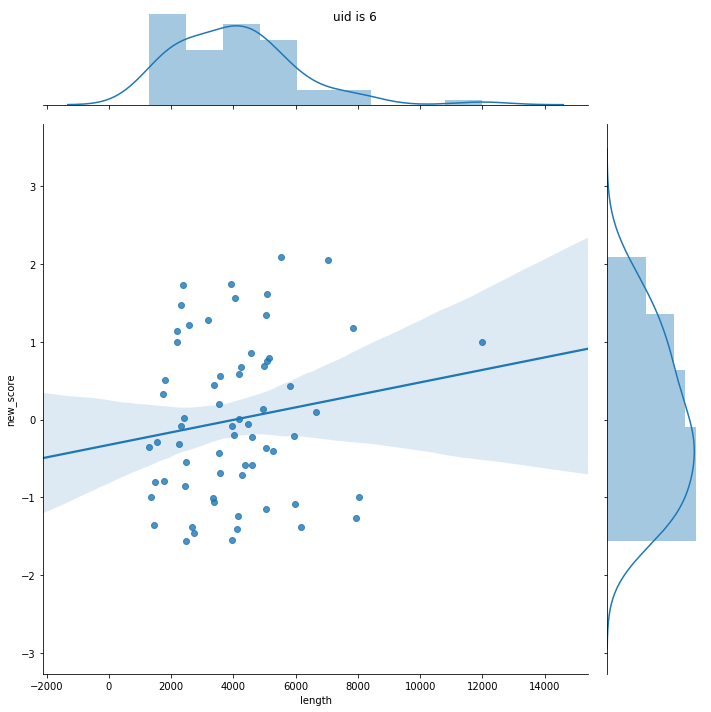

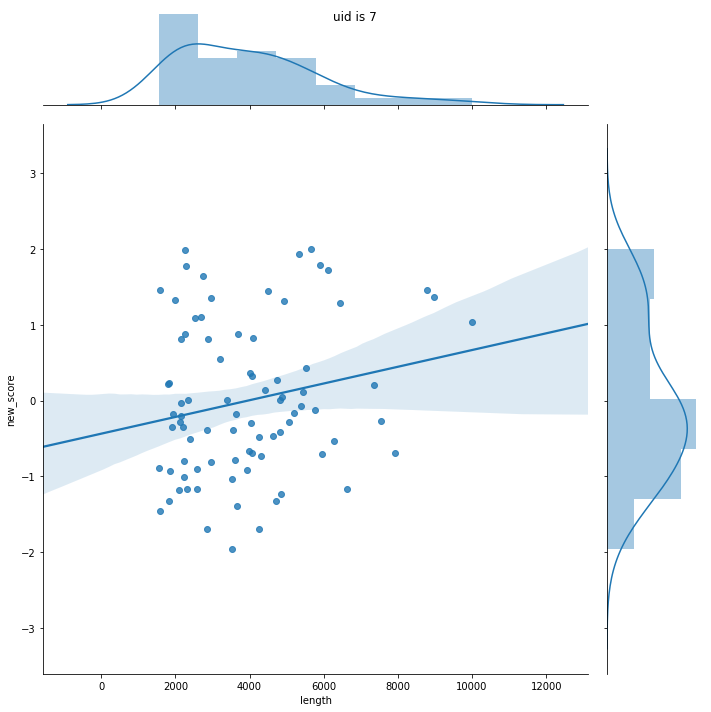

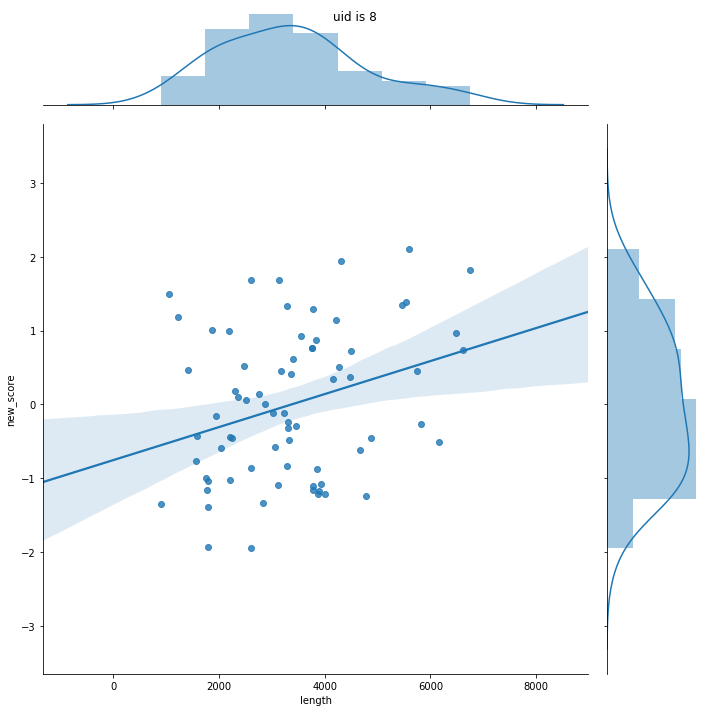

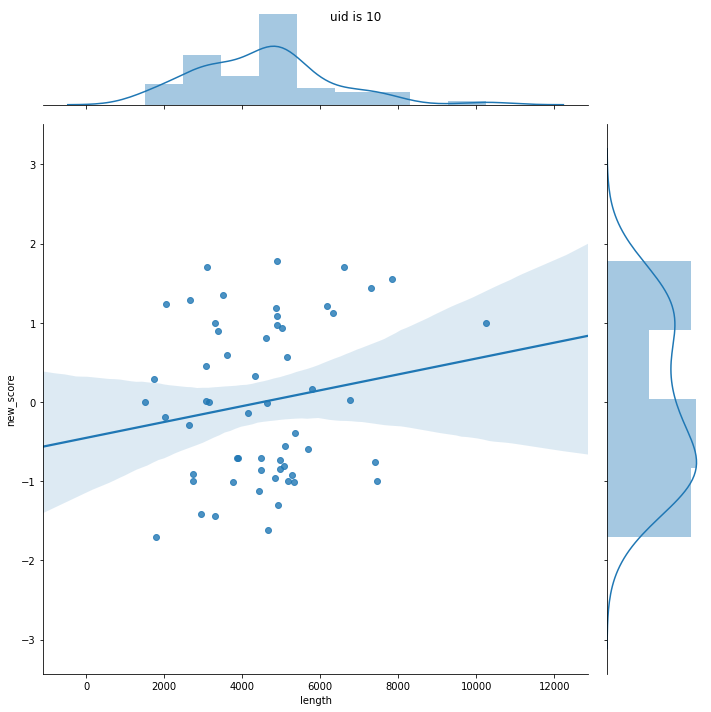

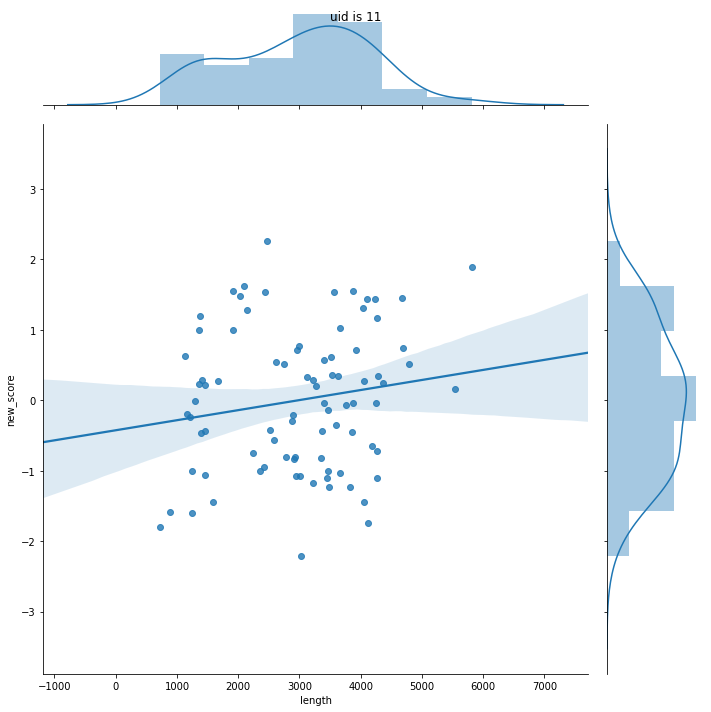

In [15]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="length", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

correlation between force and new_score 

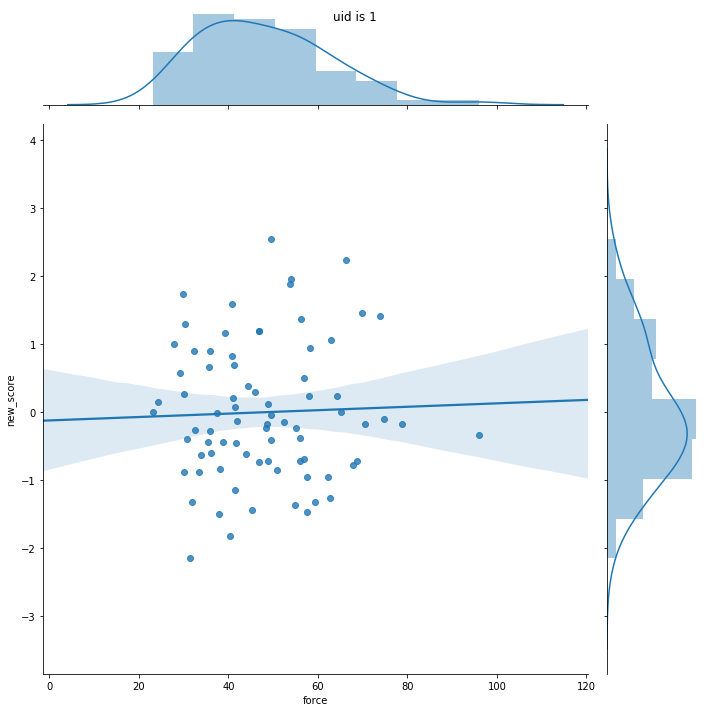

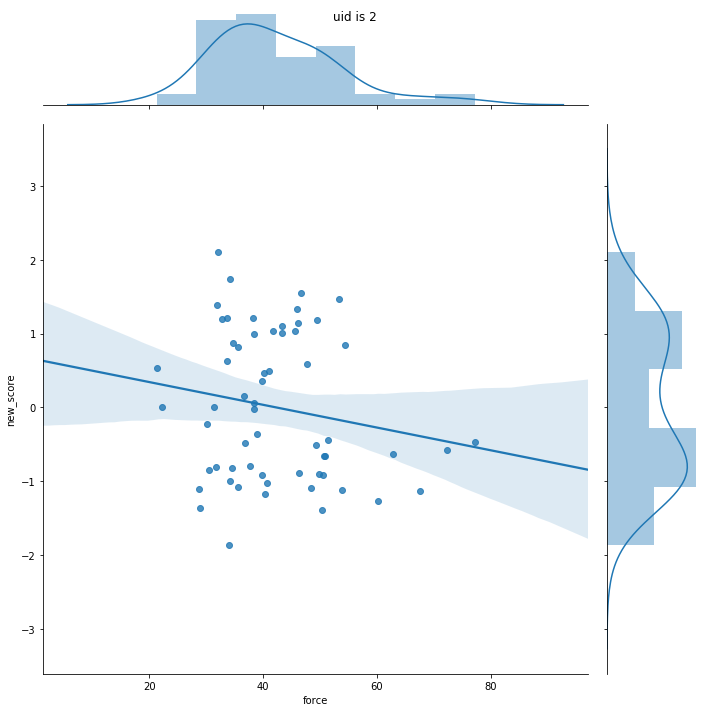

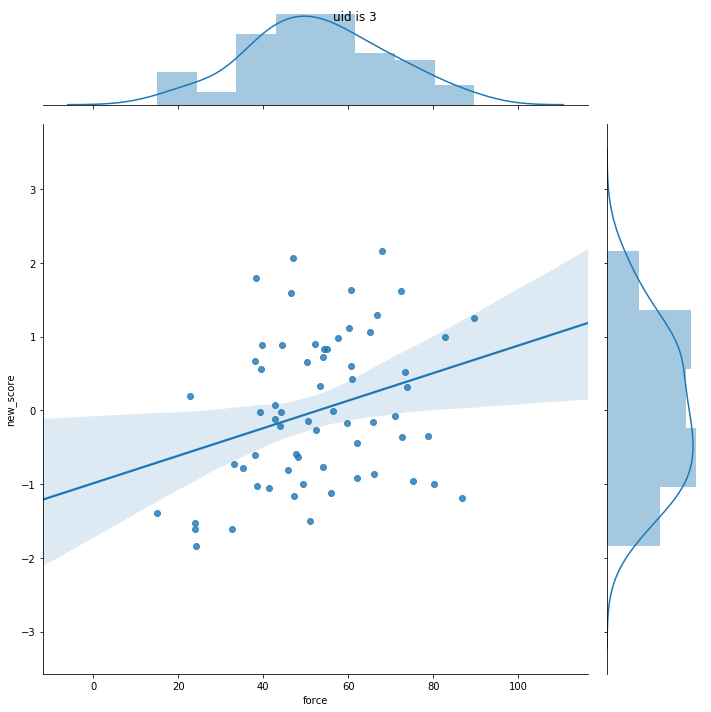

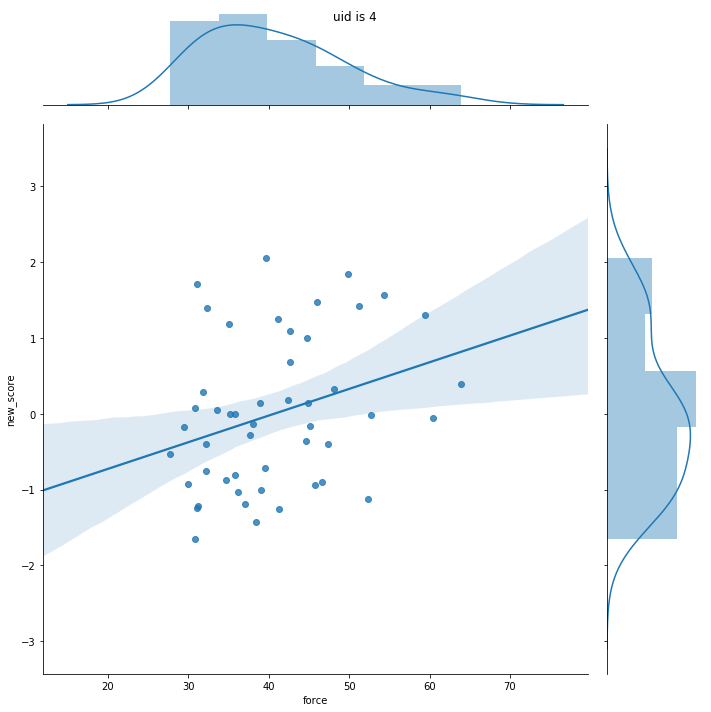

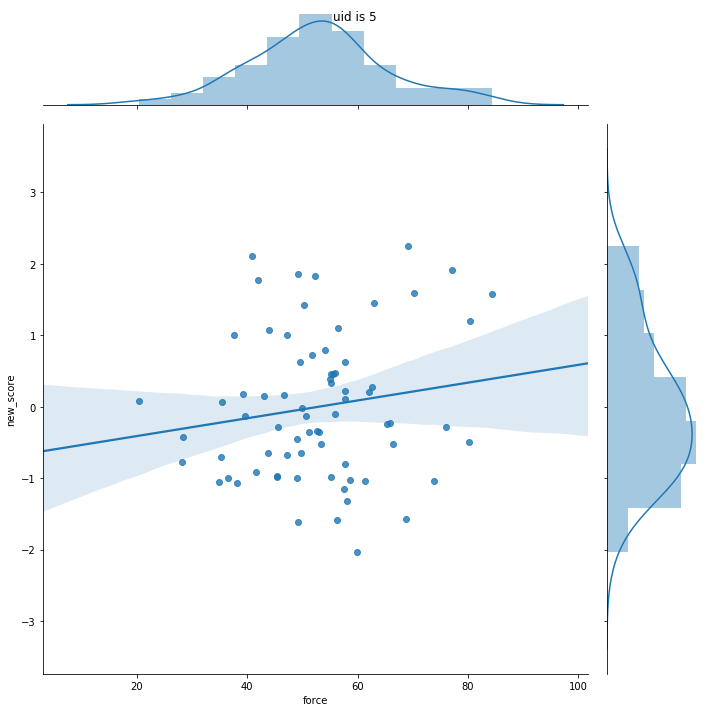

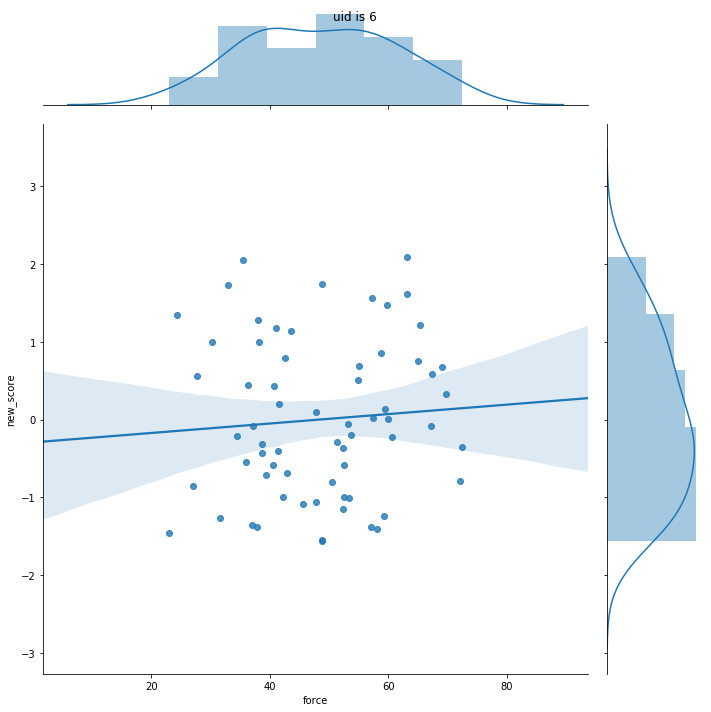

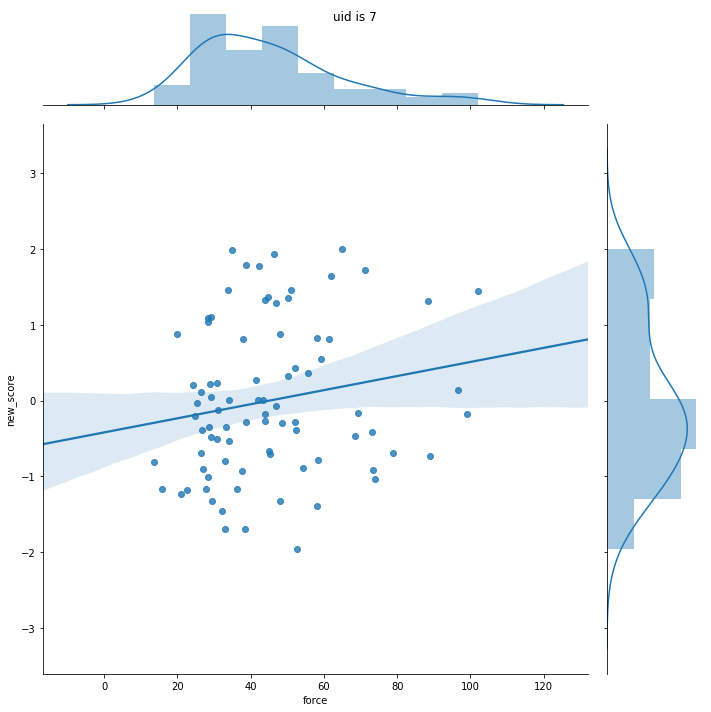

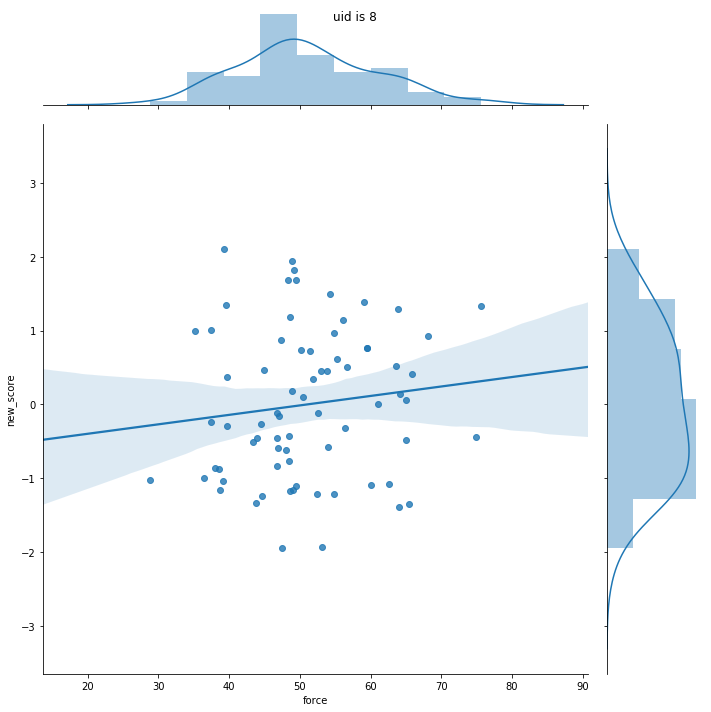

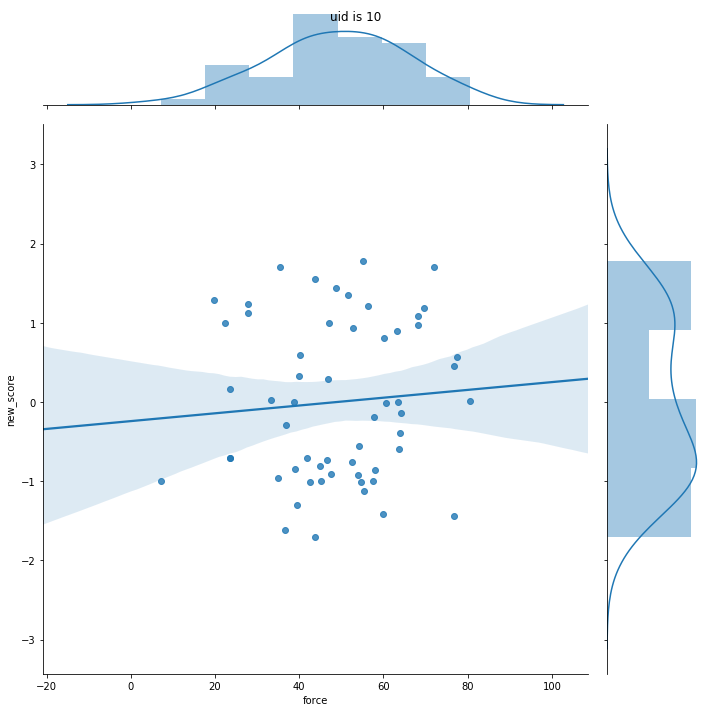

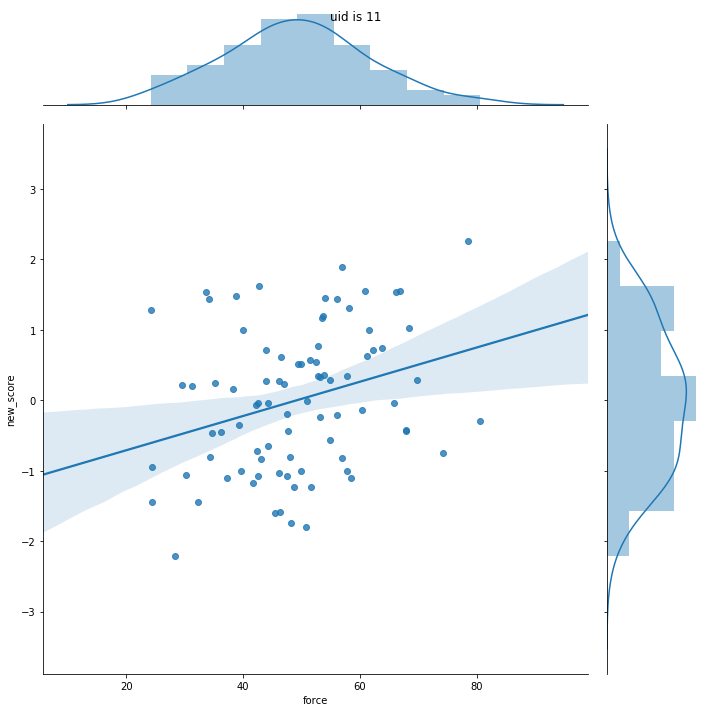

In [16]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="force", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

correlation between new_score and training day 

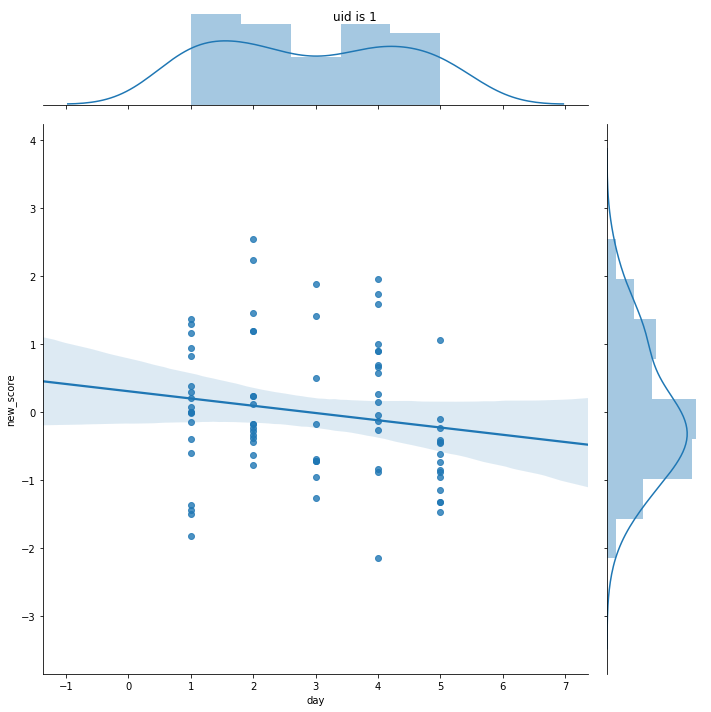

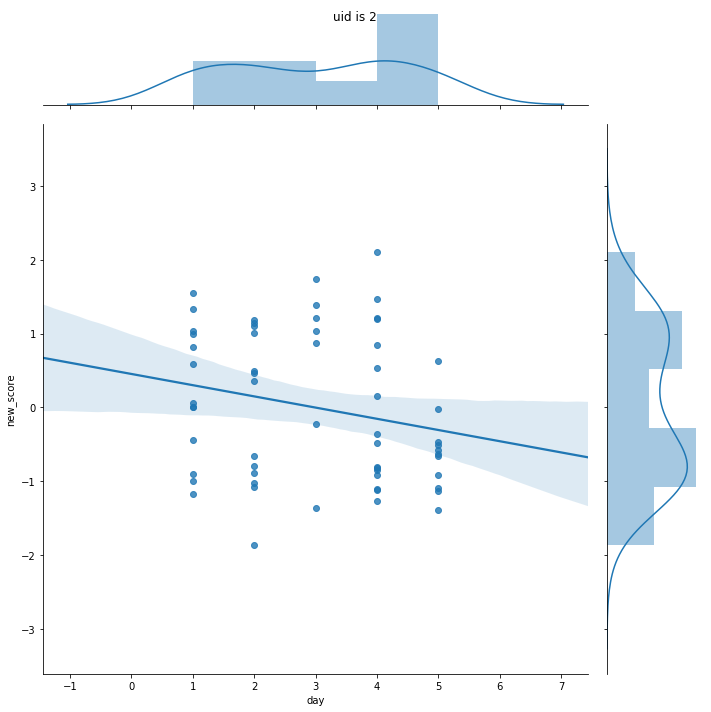

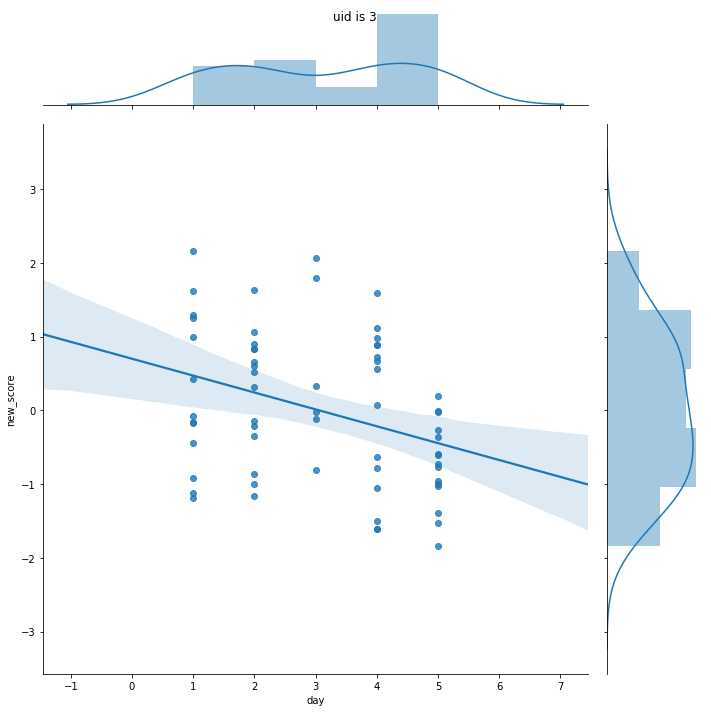

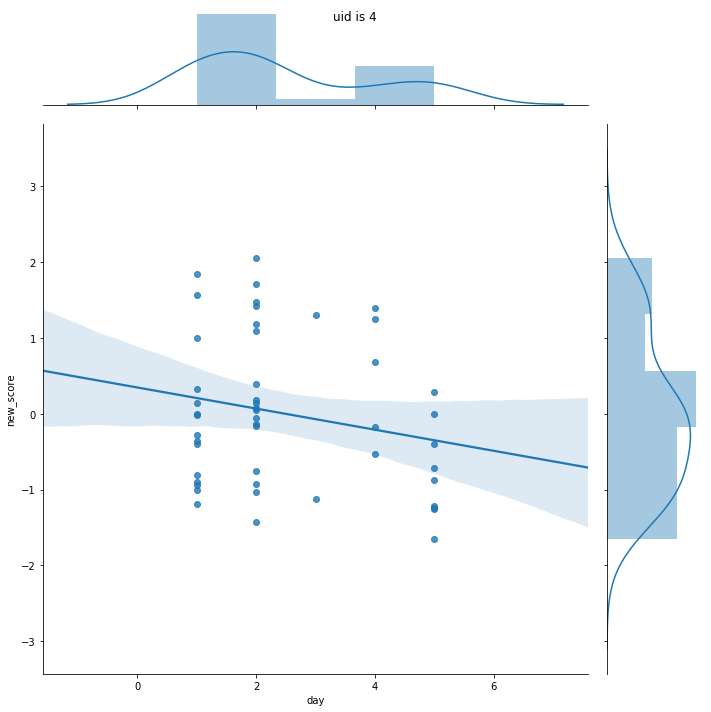

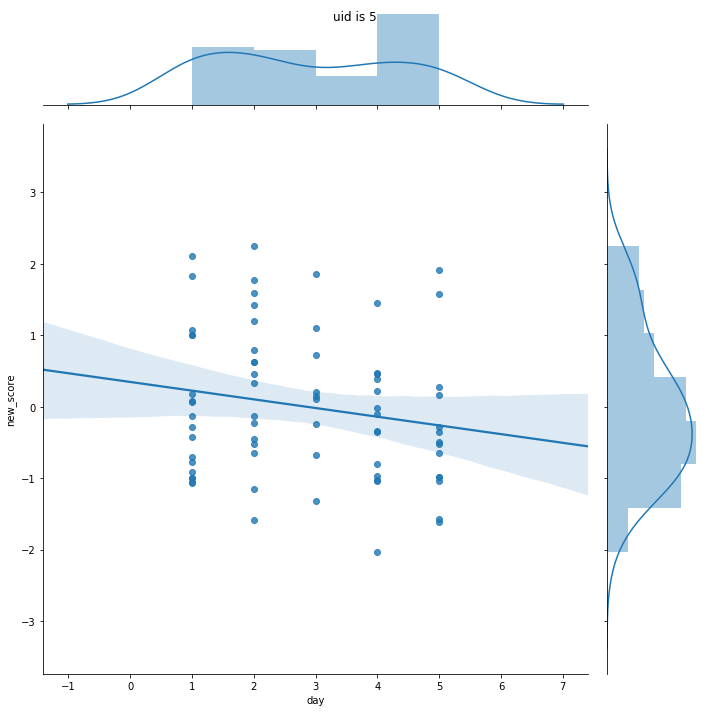

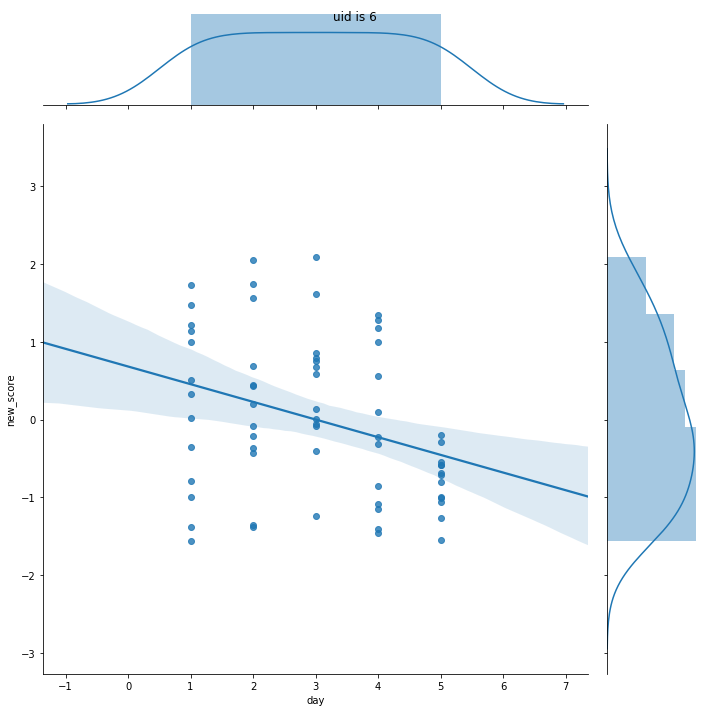

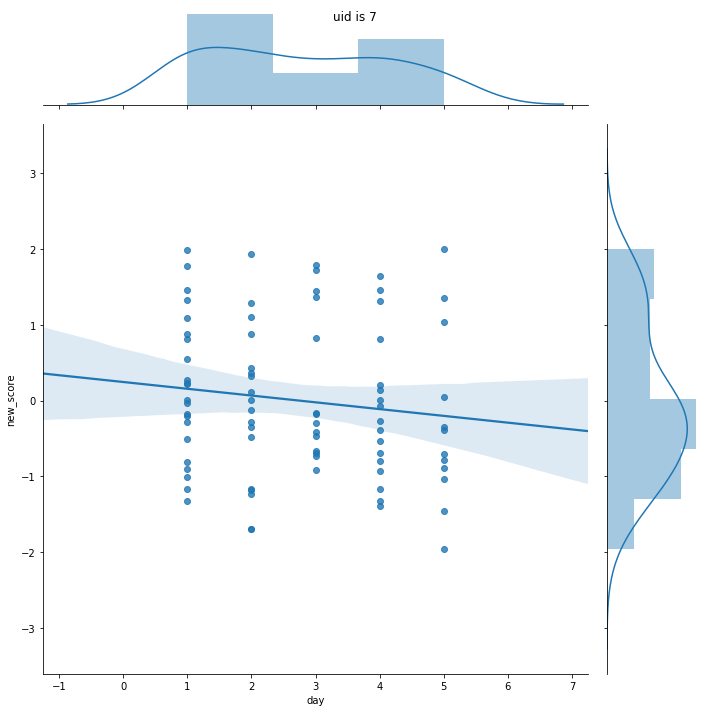

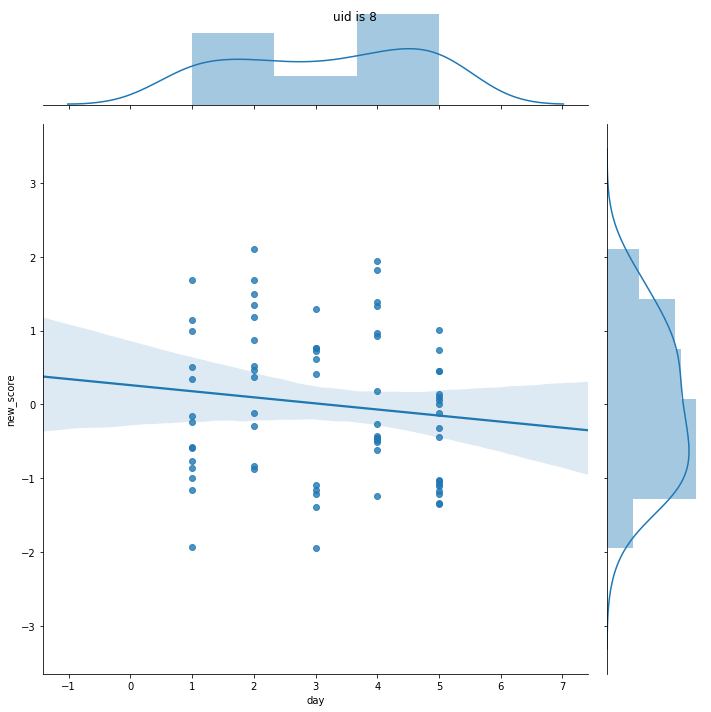

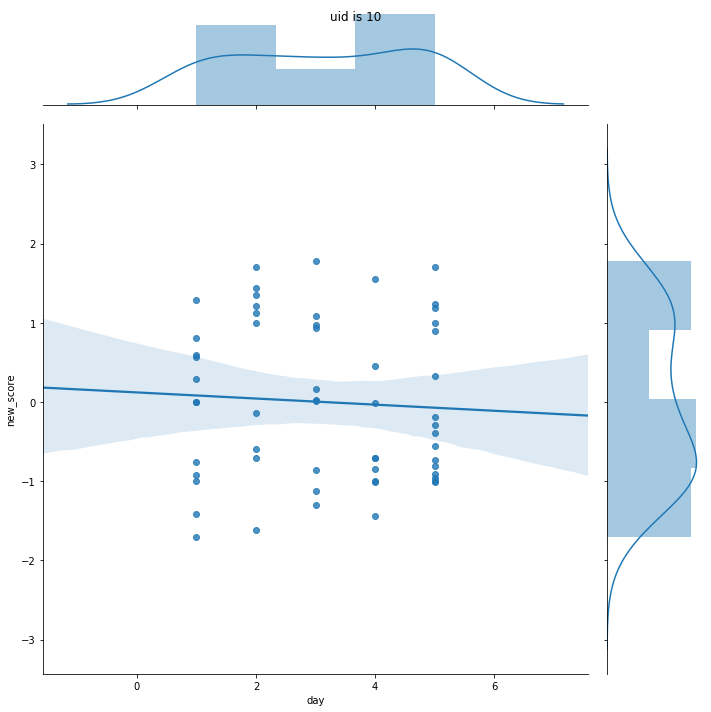

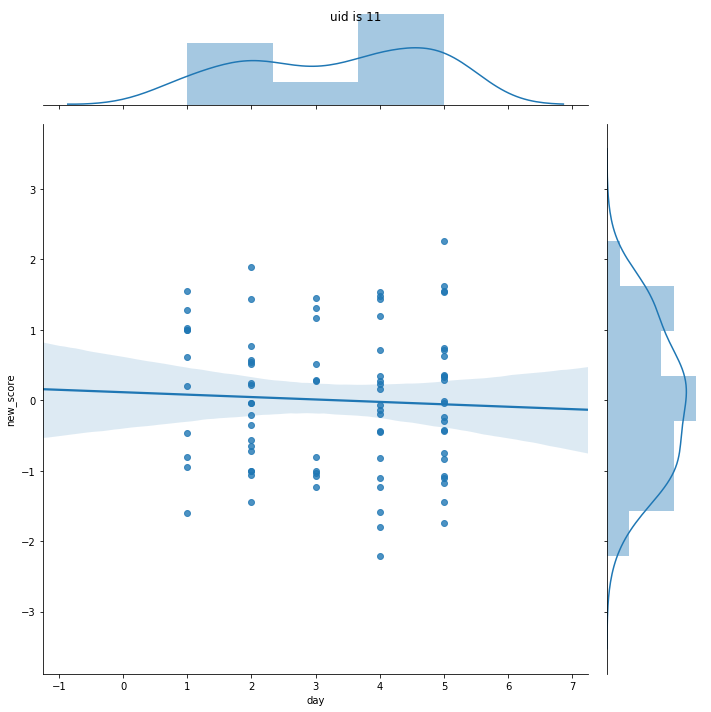

In [17]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="day", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

correlation between new_score and exc_times 

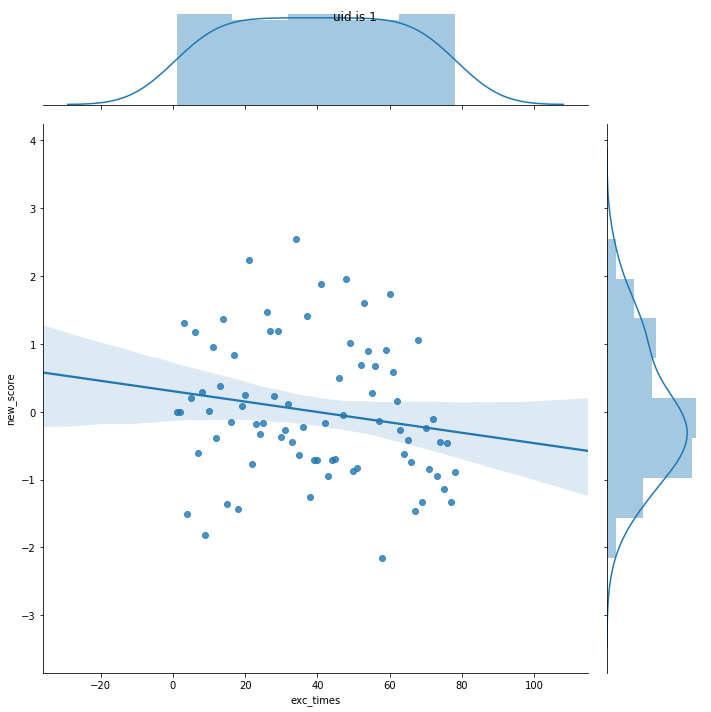

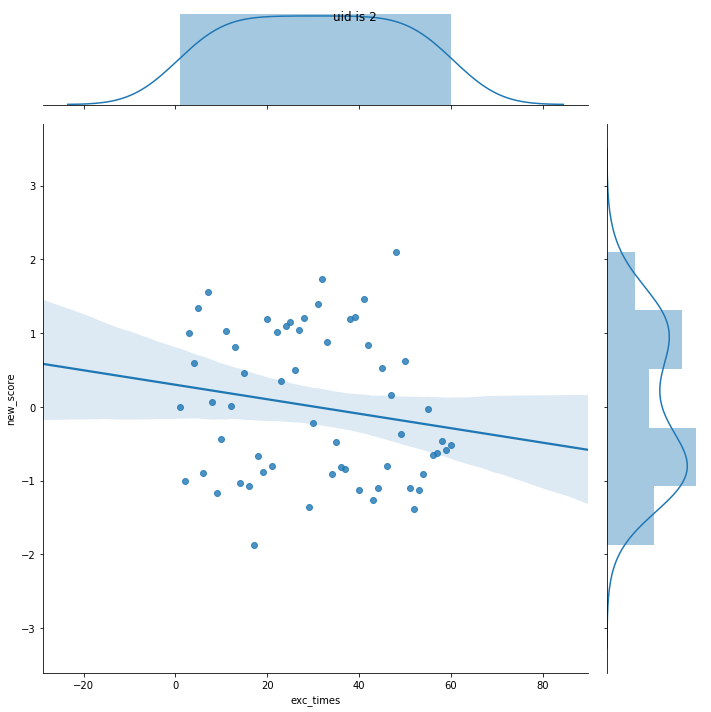

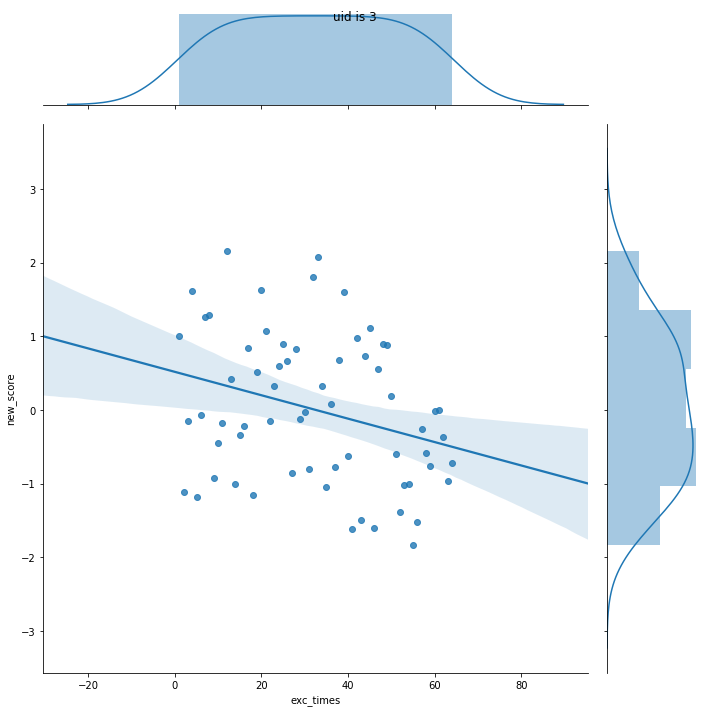

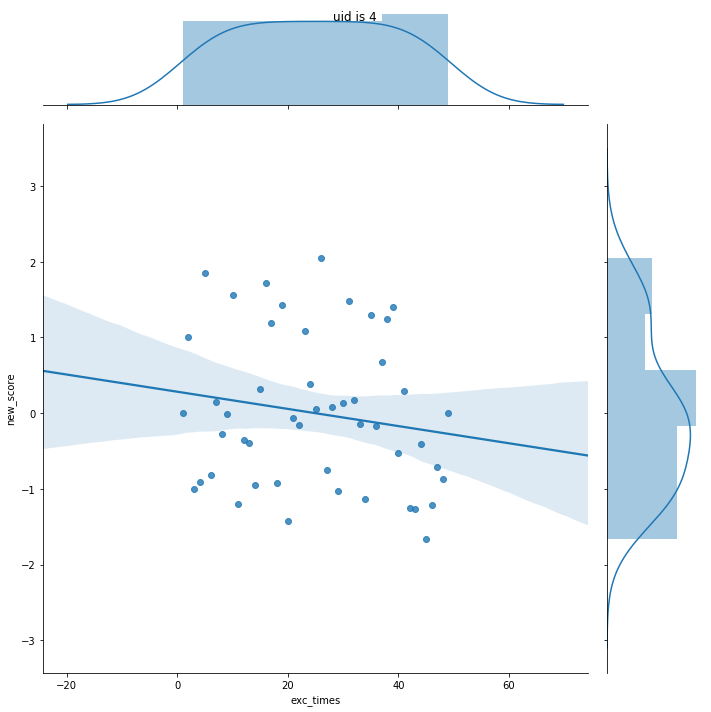

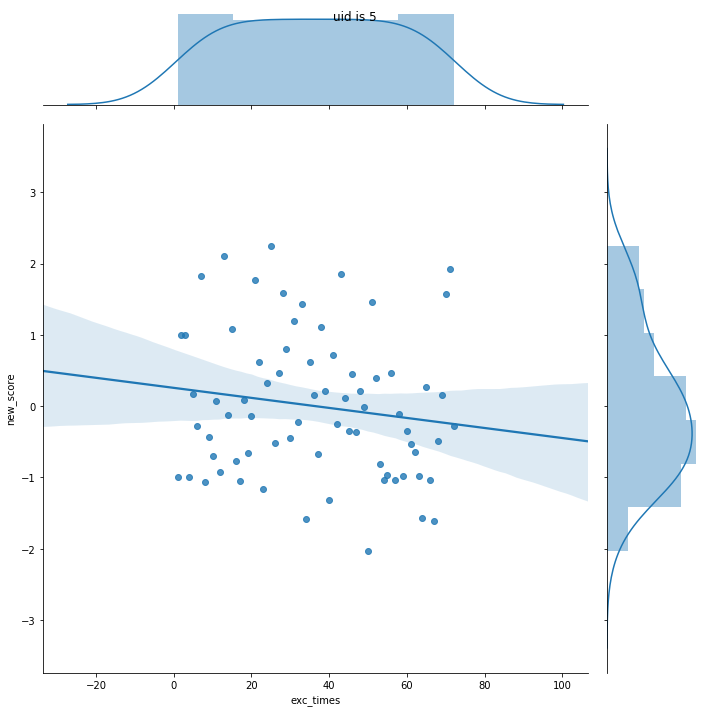

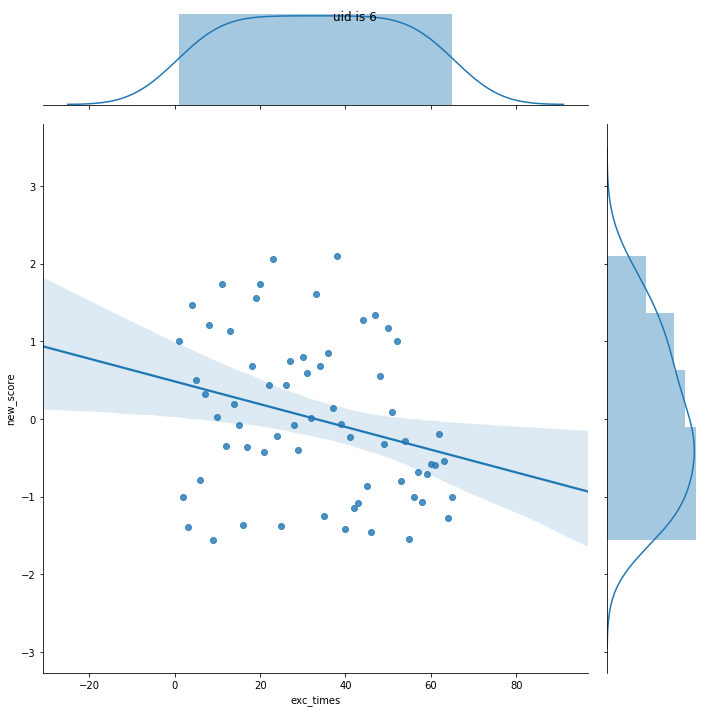

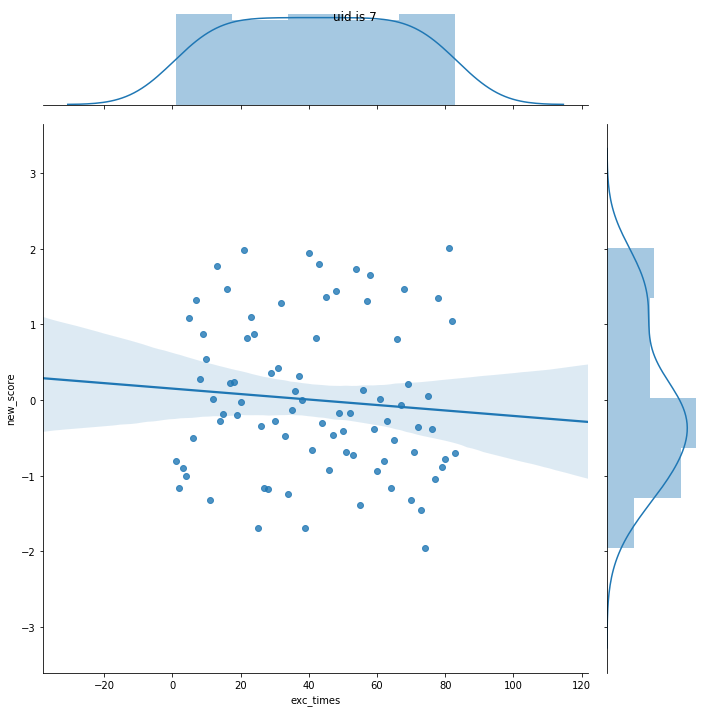

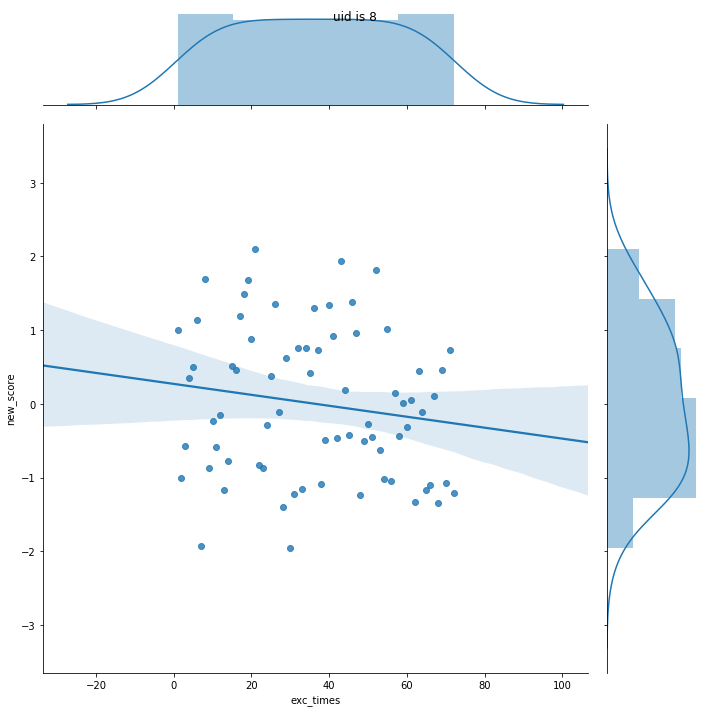

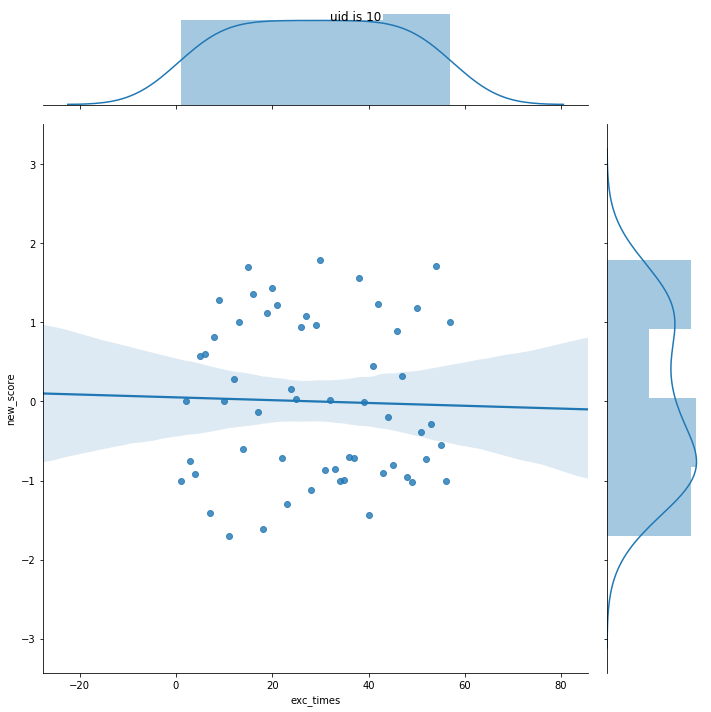

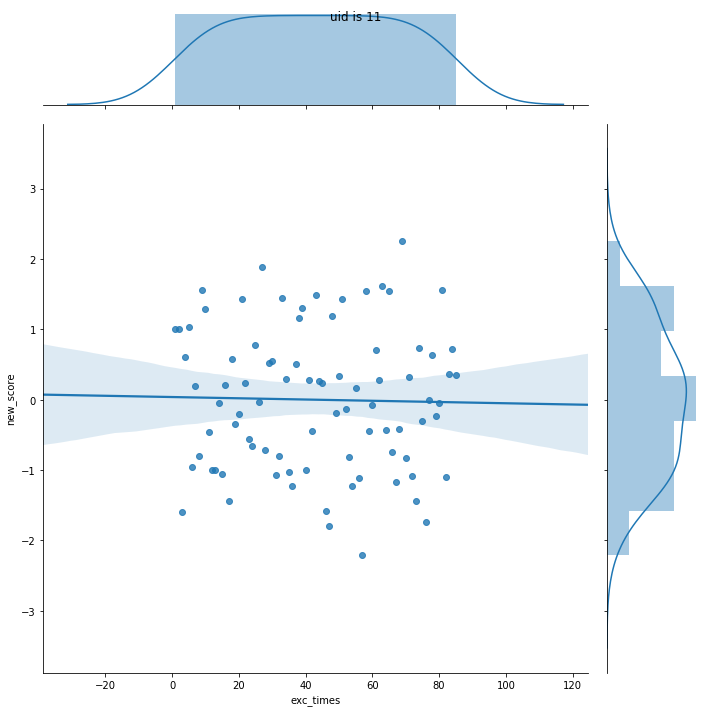

In [18]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="exc_times", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))